### ASTR 8070: Astrostatistics
***S. R. Taylor***
___

# Homework 5
### Due: Saturday, Mar 2nd at 11.59pm CST
---

## Only one problem this week

This problem uses a dataset in `/coursework/homeworks/hw_data/`.

1) Read in `hw5_data_1.npy`. This is a (10 x 3) numpy array, containing some time-series measurements. It could be flux measurements from a star or some other transient. The first column is time (arbitrary units), the second column is the flux (arbitrary units), and the third column are homoescedastic measurement uncertainties on the flux. Plot this data with the uncertainties.

2) One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 

3) Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

### Solution

#### 1.1

In [2]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format='retina'

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import norm

import scipy

In [3]:
hw5_data_1 = np.load('/Users/toralcm/repos/astr_8070_s24/coursework/homeworks/hw_data/hw5_data_1.npy');

In [4]:
hw5_data_1

array([[ 0.46954762,  8.83485016,  1.        ],
       [ 1.87898004, 10.90082649,  1.        ],
       [ 2.01075462, 10.46566244,  1.        ],
       [ 2.02183974,  8.46375631,  1.        ],
       [ 3.91877923, 11.48825219,  1.        ],
       [ 6.02254716, 11.89588918,  1.        ],
       [ 6.41474963, 11.17877957,  1.        ],
       [ 7.10360582,  9.82007516,  1.        ],
       [ 8.71292997,  8.92924738,  1.        ],
       [ 9.39405108, 11.05445173,  1.        ],
       [ 9.60984079,  9.59682305,  1.        ],
       [ 9.71012758, 11.22244507,  1.        ],
       [10.20448107, 10.20827498,  1.        ],
       [11.03751412, 10.97663904,  1.        ],
       [11.82744259, 10.3563664 ,  1.        ],
       [11.8727719 , 10.70657317,  1.        ],
       [12.01965612, 10.01050002,  1.        ],
       [12.89262977, 11.78587049,  1.        ],
       [13.17978624, 10.12691209,  1.        ],
       [13.81829513, 10.40198936,  1.        ],
       [14.33532874, 11.8831507 ,  1.   

In [5]:
#label columns
time = hw5_data_1[:,0]
flux = hw5_data_1[:,1]
uncertainties = hw5_data_1[:,2]

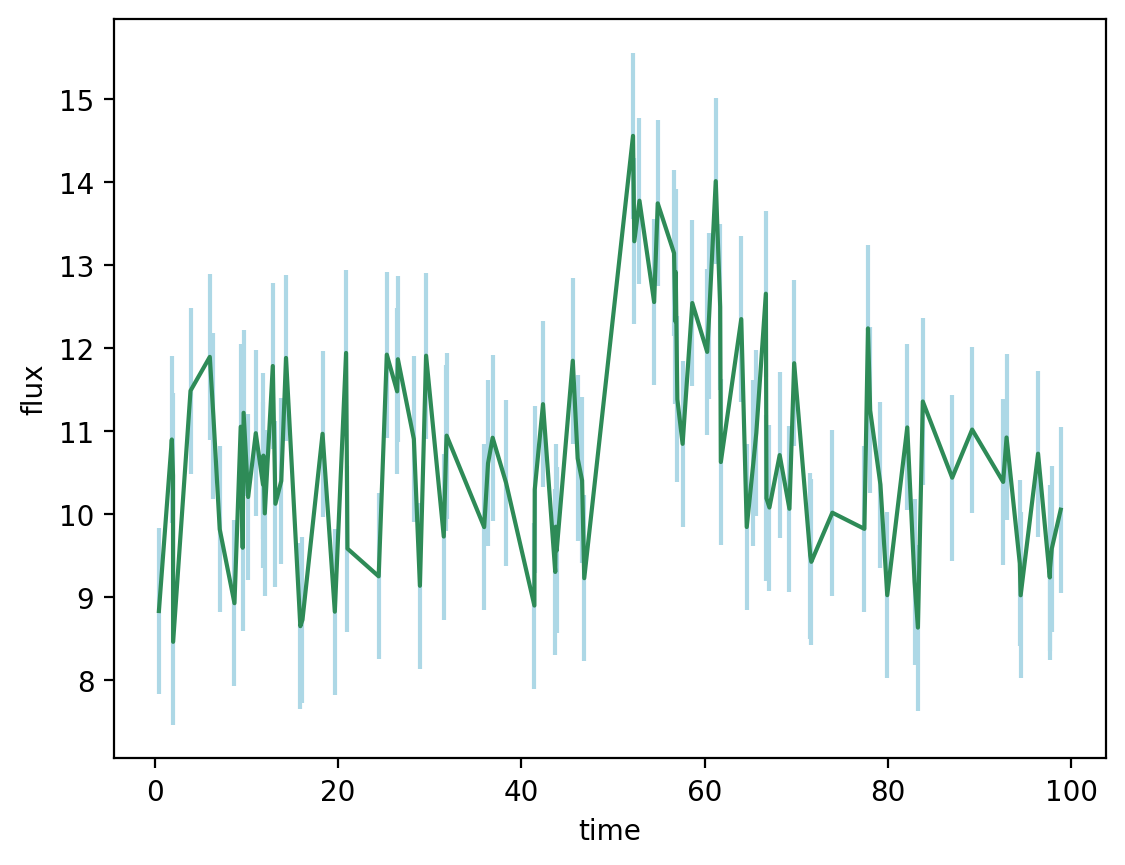

In [6]:
#plot 
plt.errorbar(time, flux, yerr=uncertainties,color='seagreen', ecolor='lightblue')
plt.xlabel('time')
plt.ylabel('flux')
plt.show()

#### 1.2

 One possible model for this data is a sharp burst with an exponential tail rising above a nominal background level. This model can be described as:

$y = b$, for $t<t_0$

$y = b + A\exp[-\alpha(t-t_0)]$, for $t\geq t_0$

where $b$ is the background amplitude, $A$ is the burst amplitude, $t_0$ is the burst epoch, and $\alpha$ encodes how rapidly the burst dies off.

Code this burst model, and code a likelihood function for this data with the burst model. *Hint: This is similar in spirit to the likelihood when fitting polynomials to data, except now $x$ is time, and the polynomial model is now the burst model.* 


In [362]:

#parameters = b, A, t_0, alpha

#define burst model
def burst_model(X, t):
    b, A, t_0, alpha = X
    y_predict = np.zeros_like(t)
    for i, t_i in enumerate(t):
        if t_i < t_0:
            y_predict[i] = b
        else:
            y_predict[i] = b + A * np.exp(np.exp(-alpha) * (t_i - t_0))
    return y_predict
       
#likelihood funciton
def logL(X, data, t, uncertainties, model=burst_model):
    b, A, t_0, alpha = X
    y_predict = model([b, A, t_0, alpha], t)
    data2 = y_predict - data
    log_pdf_L = ((data2/uncertainties)**2) #from lecture 6, lnL = constant - 0.5chi^2 for gaussian uncertainties
    return -0.5 * np.sum(log_pdf_L)


In [222]:
#this was another likelihood function i tried, but the trace plots looked terrible
#def logL(X, hw5_data_1, model=burst_model):
    #time = hw5_data_1[:,0]
    #flux = hw5_data_1[:,1]
    #uncertainties = hw5_data_1[:,2]
    #model_predict = model(X, time)
    #return np.sum(scipy.stats.norm.logpdf(flux, loc=model_predict, scale=uncertainties))

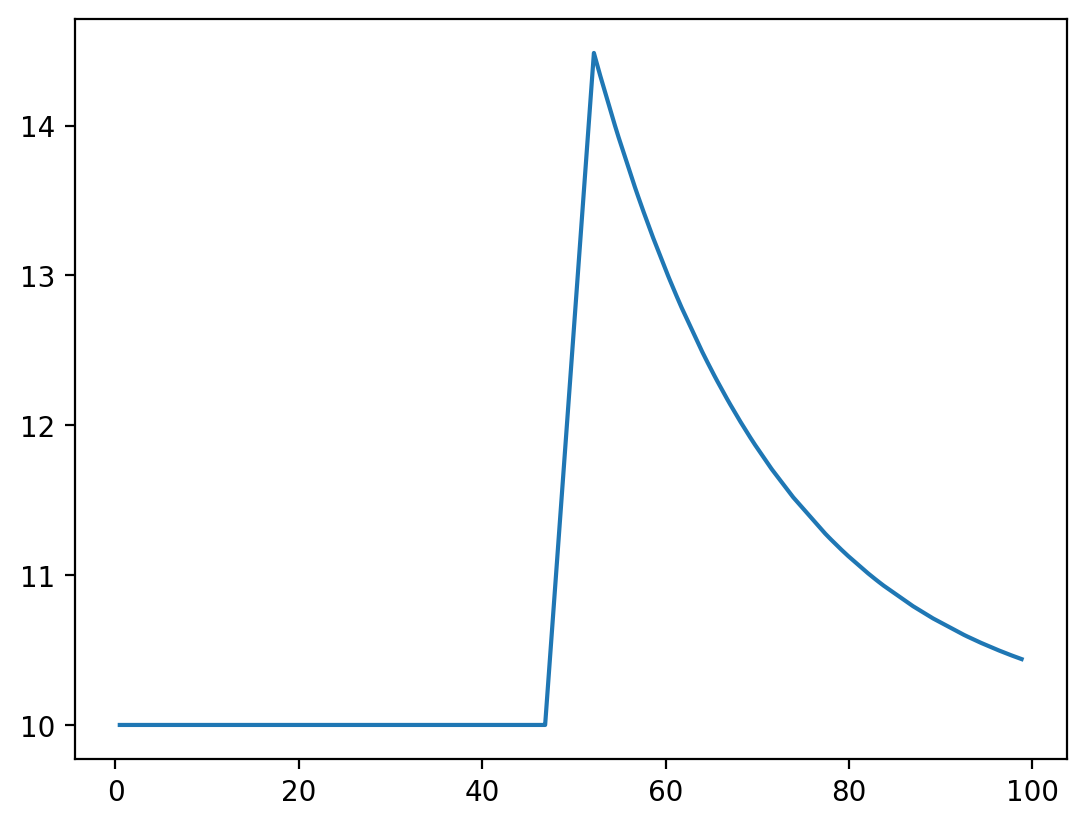

In [224]:
#checking if the burst model works correctly
c = burst_model(X= [10, 5, 50, -3], t=time)
plt.plot(time, c)
plt.show()

#### 1.3

Using one of the MCMC codes that we looked at in class (`emcee`, `pymc3`, `PTMCMCSampler`) perform a Bayesian analysis that recovers an MCMC chain of posterior probability samples for the joint parameter space of $\{b,A,t_0,\alpha\}$. You must decide on how many samples are appropriate for running your MCMC. For your priors, make them $b\in \mathrm{Uniform}[0,50]$, $A\in \mathrm{Uniform}[0,50]$, $t_0\in \mathrm{Uniform}[0,100]$, and $\ln\alpha\in \mathrm{Uniform}[-5,5]$.

In [242]:
#estimate values of each parameter 
b_est = 10

#it looks like there is a burst somewhere between 40 and 60 (in arbitrary time units)
#the flux at these points looks to be about 9 and 14.5 (from the plot in 1.1), the difference might be a reasonable estimate for A
A_est = 5

t_0_est = 50

#from the peak of the flux, to t=100, the plot looks vaguely like e^-x
alpha_est = 2 #guessing within the range -5 and 5

In [9]:
pip install emcee

Note: you may need to restart the kernel to use updated packages.


In [245]:
#using emcee
np.random.seed(10)
import emcee

data = flux
t=time


#define all priors 

#b prior 
def b_prior(b):
    return scipy.stats.uniform.logpdf(b,loc=0,scale=50)
#A prior 
def A_prior(A):
    return scipy.stats.uniform.logpdf(A, loc=0,scale=50)

#t_0 prior
def t_0_prior(t_0):
    return scipy.stats.uniform.logpdf(t_0, 0, 100)

#alpha prior
#convert this to linear space from log space
def alpha_prior(alpha):
    return scipy.stats.uniform.logpdf(alpha, -5, 10) 


#joint posterior 
# emcee wants ln of posterior pdf -- from lecture 11 
def log_posterior(X, data, t, uncertainties):
    b, A, t_0, alpha = X
    L = logL(X, data, t, uncertainties)
    priors = b_prior(b) + A_prior(A) + t_0_prior(t_0) + alpha_prior(alpha) 
    joint_posterior = L * priors #posterior = L * priors for a joint posterior
    return joint_posterior



#MCMC using emcee
ndim = 4 #parameters
nwalkers = 10
nsteps = 200000

#initialize parameters with estimated parameter values from the cell above
starting_guesses = np.array([b_est, A_est,t_0_est, alpha_est]) + 1e-4 * np.random.randn(nwalkers, ndim)

#sampler
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=[data, t, uncertainties])
sampler.run_mcmc(starting_guesses, nsteps)

#from lecture 11:
#burn = 1000  # "burn-in" period to let chains stabilize
emcee_trace  = sampler.chain[:, :, :].reshape(-1, ndim) #leave out burn-in for now
 
print("done")


done


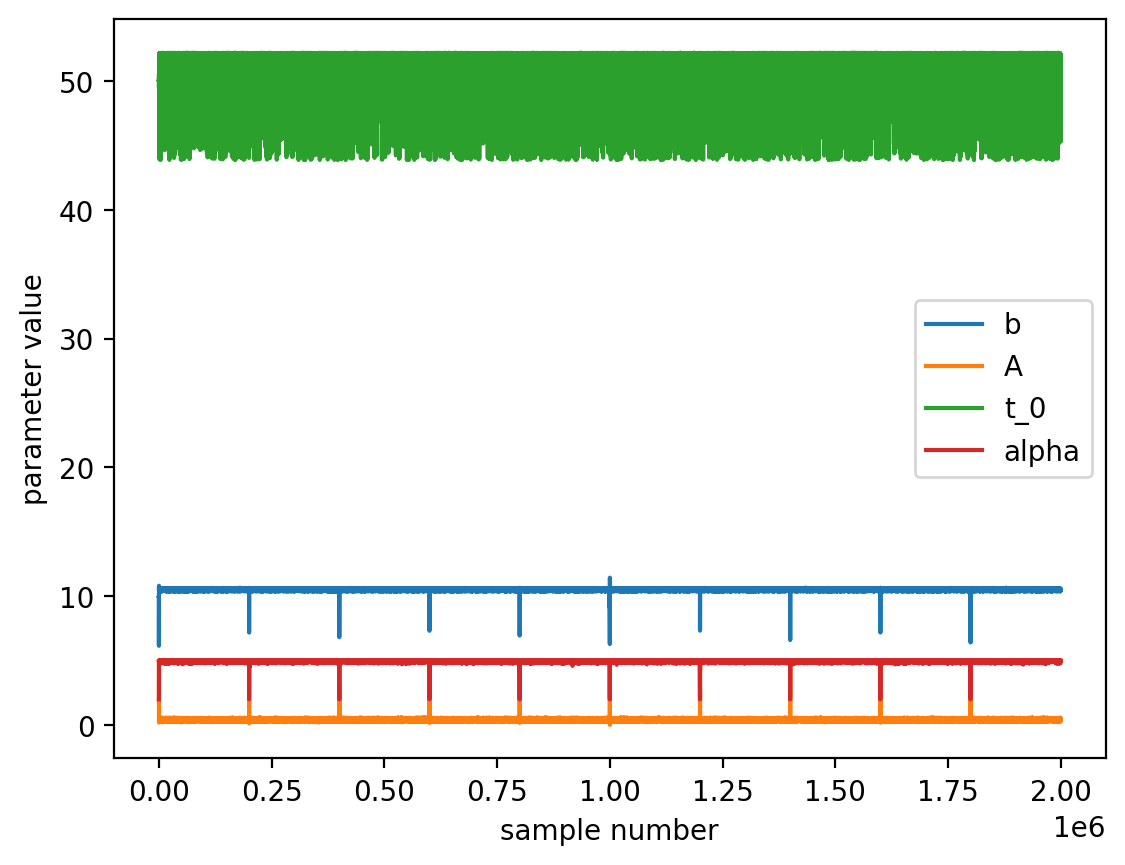

In [263]:
#trace plot -- all parameters on one plot
xgrid= np.linspace(1, emcee_trace.shape[0], emcee_trace.shape[0])
plt.plot(xgrid, emcee_trace[:,0], label = 'b')
plt.plot(xgrid, emcee_trace[:,1], label = 'A')
plt.plot(xgrid, emcee_trace[:,2], label = 't_0')
plt.plot(xgrid, emcee_trace[:,3], label = 'alpha')

plt.xlabel('sample number')
plt.ylabel('parameter value')
plt.legend()
plt.show()

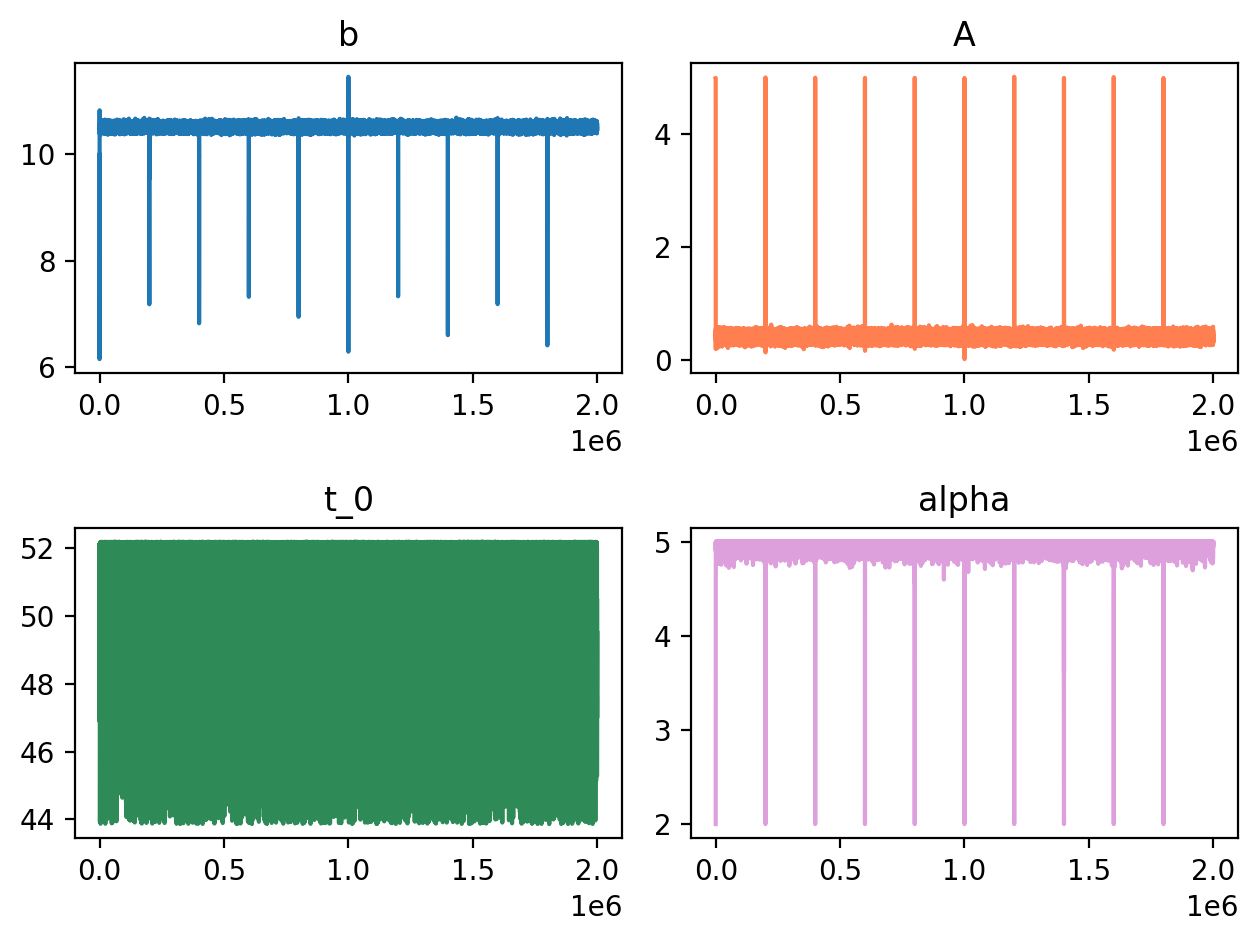

In [247]:
#trace plots -- all parameters in their own plot

xgrid= np.linspace(1, emcee_trace.shape[0], emcee_trace.shape[0])

y1 = emcee_trace[:,0]

y2 = emcee_trace[:,1]

y3 = emcee_trace[:,2]

y4 = emcee_trace[:,3]

fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(xgrid, y1)
axes[0, 0].set_title('b')

axes[0, 1].plot(xgrid, y2, color='coral')
axes[0, 1].set_title('A')


axes[1, 0].plot(xgrid, y3, color='seagreen')
axes[1, 0].set_title('t_0')

axes[1, 1].plot(xgrid, y4, color='plum')
axes[1, 1].set_title('alpha')

plt.tight_layout()
plt.show()

The x-axes on each plot is sample number, and the y-axes are the respective parameter values


The plots don't look great...but there are parts that look like fuzzy caterpillars. 
(also note that this is while burn= ... is commented out of my code -- in 1.4 the trace plots look more reasonable)

#### 1.4

4) Perform an appropriate check to burn-in your chain, and thin the chain by selecting only points every auto-correlation length. If you are left with a small number of samples after thinning then you may need to run your MCMC for longer in (3).

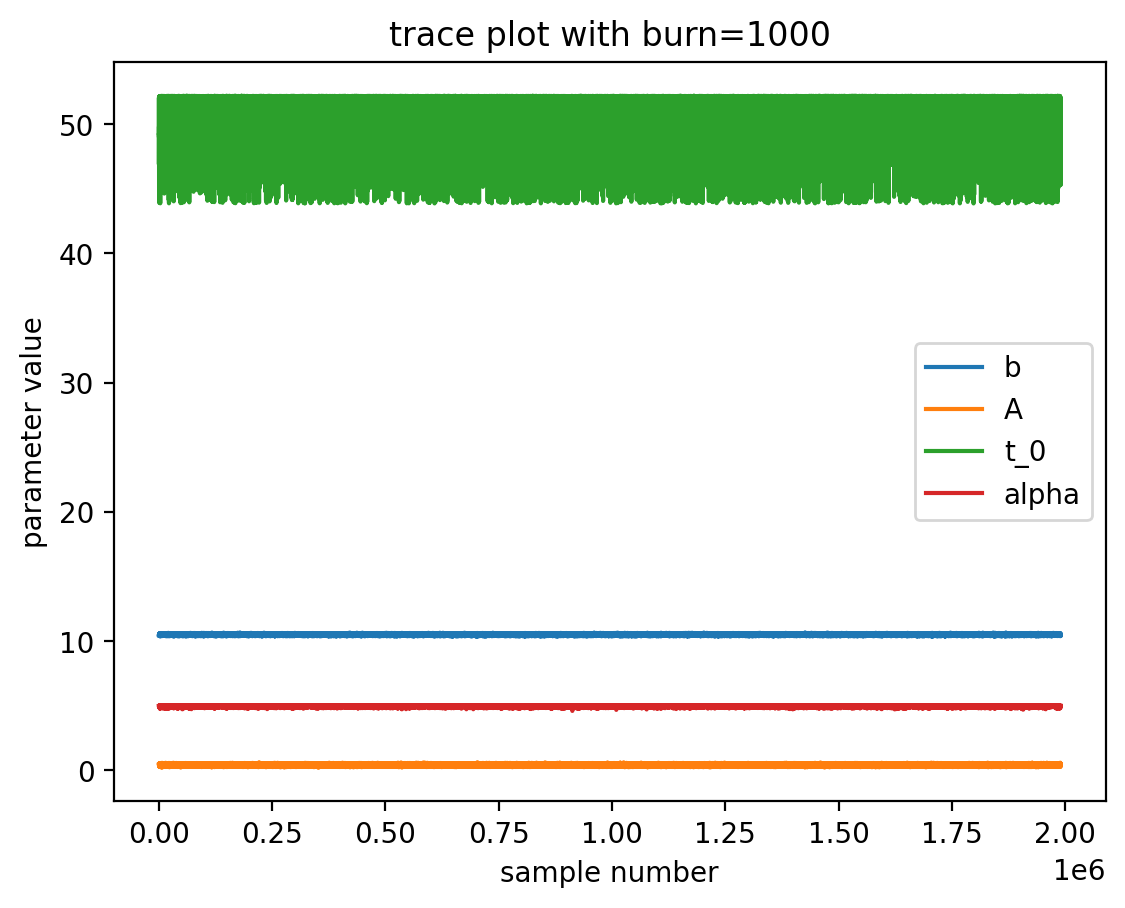

In [262]:
#check to burn in = trace plots

#add burn-in
burn = 1000  # "burn-in" period to let chains stabilize
emcee_trace_b = sampler.chain[:, burn:, :].reshape(-1, ndim)

#make trace plots 
xgrid= np.linspace(1, emcee_trace_b.shape[0], emcee_trace_b.shape[0])

plt.plot(xgrid, emcee_trace_b[:,0], label = 'b')
plt.plot(xgrid, emcee_trace_b[:,1], label = 'A')
plt.plot(xgrid, emcee_trace_b[:,2], label = 't_0')
plt.plot(xgrid, emcee_trace_b[:,3], label = 'alpha')

plt.title('trace plot with burn=1000')
plt.xlabel('sample number')
plt.ylabel('parameter value')
plt.legend()
plt.show()

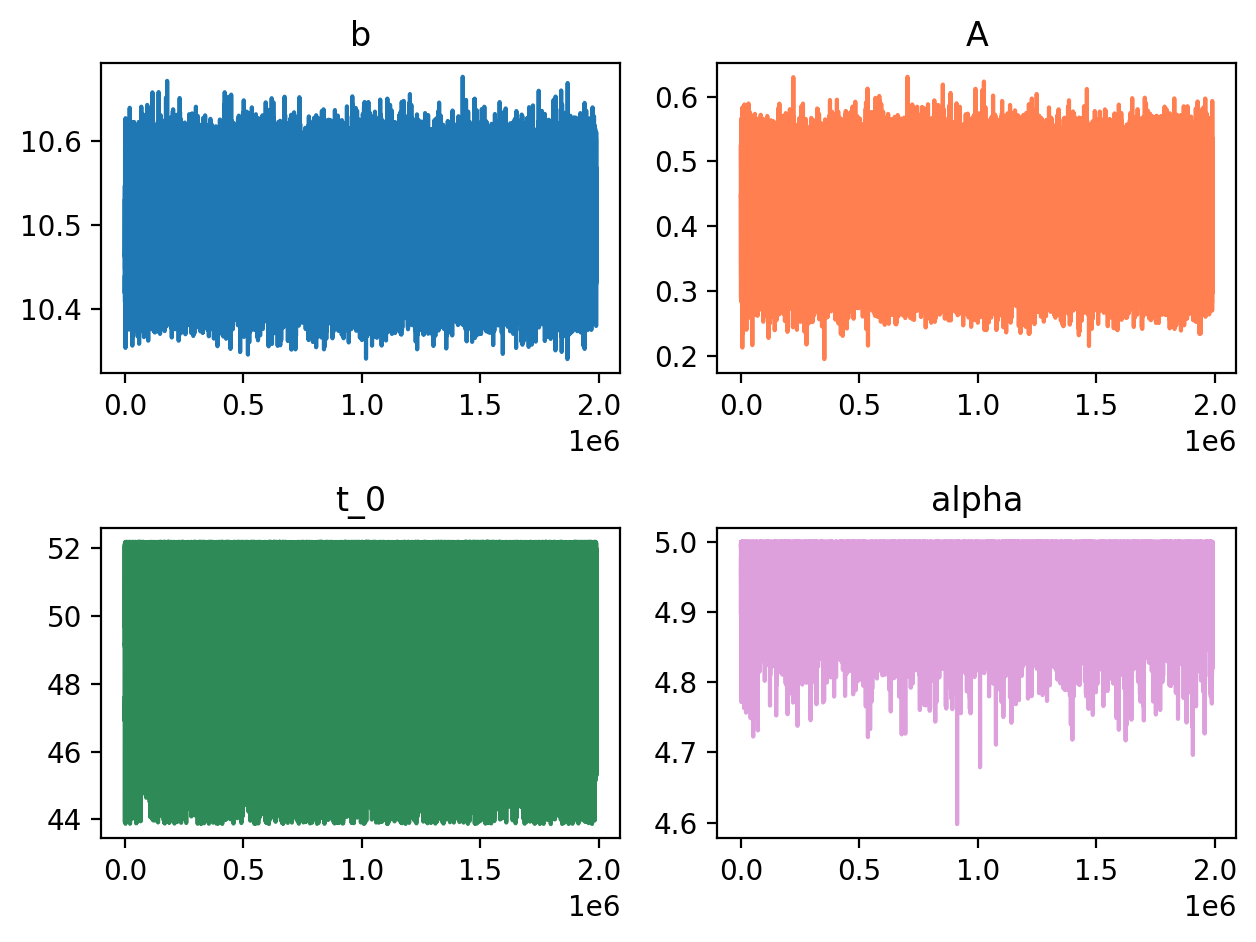

In [249]:
#trace plots -- all parameters in their own plot

xgrid= np.linspace(1, emcee_trace_b.shape[0], emcee_trace_b.shape[0])

y1 = emcee_trace_b[:,0]

y2 = emcee_trace_b[:,1]

y3 = emcee_trace_b[:,2]

y4 = emcee_trace_b[:,3]

fig, axes = plt.subplots(2, 2)

axes[0, 0].plot(xgrid, y1)
axes[0, 0].set_title('b')

axes[0, 1].plot(xgrid, y2, color='coral')
axes[0, 1].set_title('A')


axes[1, 0].plot(xgrid, y3, color='seagreen')
axes[1, 0].set_title('t_0')

axes[1, 1].plot(xgrid, y4, color='plum')
axes[1, 1].set_title('alpha')

plt.tight_layout()
plt.show()

The x-axes on each plot is sample number, and the y-axes are the respective parameter values

Thin the chain by selecting points every auto-correlation length

In [250]:
chains = sampler.chain[:, burn:, :].reshape(-1, ndim)

#autocorrelation time for b 
autocorrelation_b = emcee.autocorr.integrated_time(chains[:,0]) 

print(autocorrelation_b)

#thin chain
thinned_b = chains[::int(autocorrelation_b)]
#print("Points selected at every autocorrelation length:", thinned_b)

#autocorrelation time for A 
autocorrelation_A = emcee.autocorr.integrated_time(chains[:,1]) 
thinned_A = chains[::int(autocorrelation_A)]
print(autocorrelation_A)

#autocorrelation time for t_0
autocorrelation_t_0 = emcee.autocorr.integrated_time(chains[:,2]) 
thinned_t_0 = chains[::int(autocorrelation_t_0)]
print(autocorrelation_t_0)


#autocorrelation time for alpha
autocorrelation_alpha = emcee.autocorr.integrated_time(chains[:,3]) 
thinned_alpha = chains[::int(autocorrelation_alpha)]
print(autocorrelation_alpha)


[77.69669528]


/var/folders/pb/dh7ptllx07x6kqjhnzw594yr0000gn/T/ipykernel_54162/1635710908.py:9: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  thinned_b = chains[::int(autocorrelation_b)]
/var/folders/pb/dh7ptllx07x6kqjhnzw594yr0000gn/T/ipykernel_54162/1635710908.py:14: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  thinned_A = chains[::int(autocorrelation_A)]


[75.65734124]


/var/folders/pb/dh7ptllx07x6kqjhnzw594yr0000gn/T/ipykernel_54162/1635710908.py:19: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  thinned_t_0 = chains[::int(autocorrelation_t_0)]


[89.35243067]
[99.41392883]


/var/folders/pb/dh7ptllx07x6kqjhnzw594yr0000gn/T/ipykernel_54162/1635710908.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  thinned_alpha = chains[::int(autocorrelation_alpha)]


In [251]:
#final result using the largest autocorrelation time
autocorrelation = autocorrelation_alpha
thinned_chains = chains[::int(autocorrelation)]
print("Points selected at every autocorrelation length:", thinned_chains)

Points selected at every autocorrelation length: [[10.46371208  0.4471902  49.13324902  4.99342735]
 [10.52011926  0.4351905  50.4960287   4.97254272]
 [10.50538596  0.40958705 50.1927323   4.94507308]
 ...
 [10.4958044   0.4279815  48.53153941  4.97146822]
 [10.53110993  0.36170907 47.10601615  4.993497  ]
 [10.45824999  0.42017133 47.54377017  4.99460606]]


/var/folders/pb/dh7ptllx07x6kqjhnzw594yr0000gn/T/ipykernel_54162/425921683.py:3: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  thinned_chains = chains[::int(autocorrelation)]


- First autocorrelation time I got was: 86.84971466 (for b), with burn = 1000
- Second try: burn = 2000, autocorrelation time= 87.33699195 (an increase -- let burn =1000 again)
- Next, I tried to increase n_steps to see if this decreases the time(increase from n_steps=100000 to n_steps=200000)
- Increasing n_steps didn't decrease the time, but when the chain is thinned I'm left with more samples by letting n_steps=200000 than 100000
- Lastly, I found the autocorrelation time for each parameter and used the largest result to thin the entire chain, to be safe
- The autocorrelation time seems pretty large(From speaking with other students in the class, PYMC was likely a better choice than using emcee)


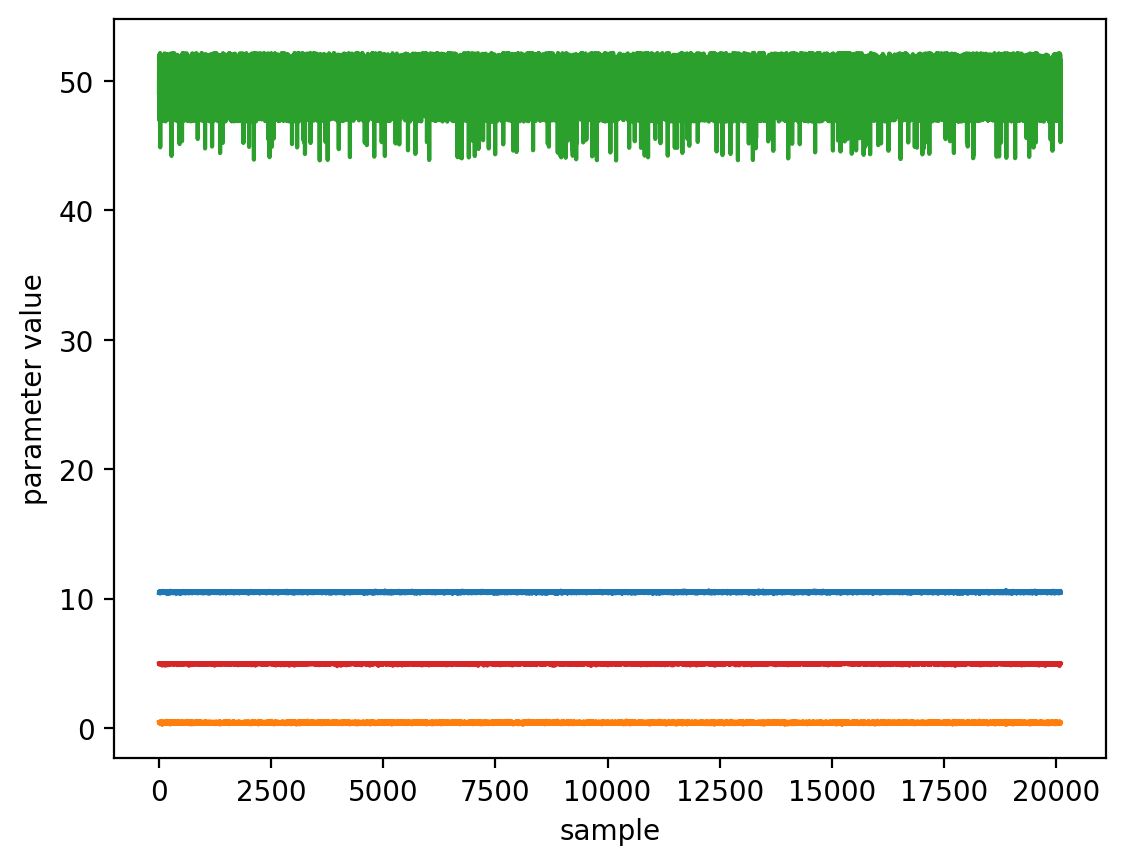

number of samples in thinned chain = 20102


In [261]:
plt.plot(range(len(thinned_chains)), thinned_chains)
plt.xlabel('sample')
plt.ylabel('parameter value')
plt.show()
print("number of samples in thinned chain =",len(thinned_chains))

#### 1.5

5) Make a corner plot of the $4$-D parameter space, with labels, $[68,95]\%$ credible levels and quantiles, and titles.

In [86]:
pip install corner

Note: you may need to restart the kernel to use updated packages.


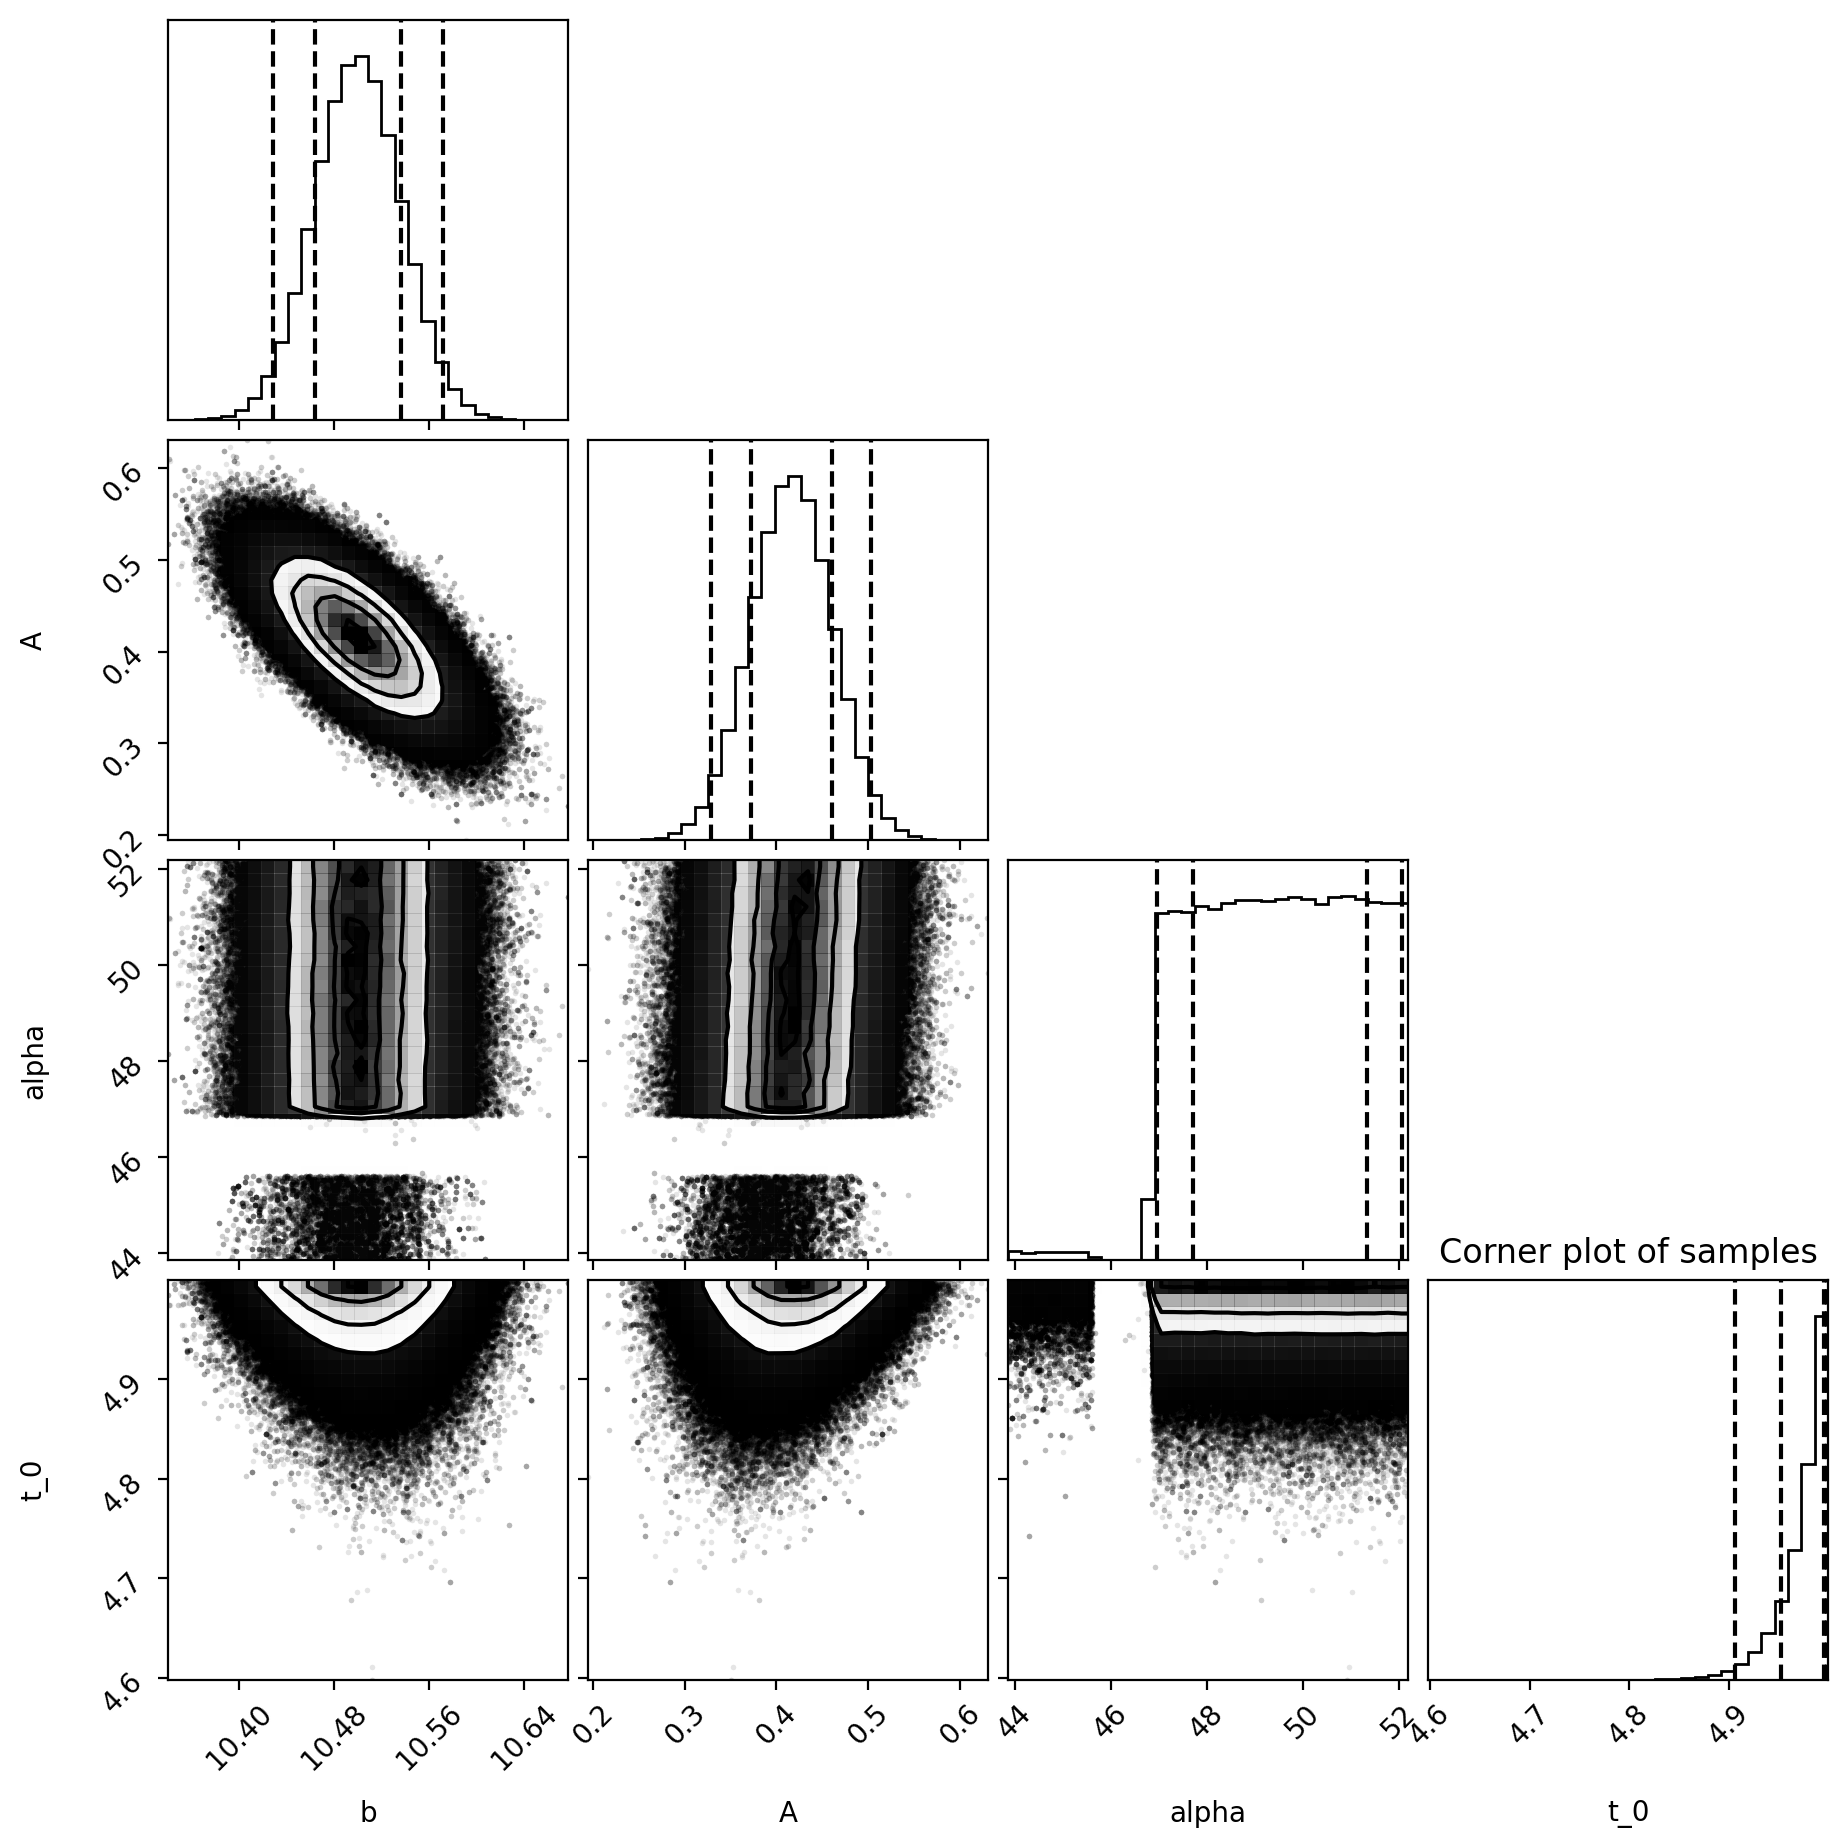

In [253]:
#corner plot of chains
import corner

#plot with labels and 68%, 95% credible regions
fig = corner.corner(data=chains,labels=['b', 'A', 'alpha', 't_0'], plot_contours=True, bins=30, quantiles=[0.16, 0.84, 0.025, 0.975])
plt.title("Corner plot of samples")
plt.show()


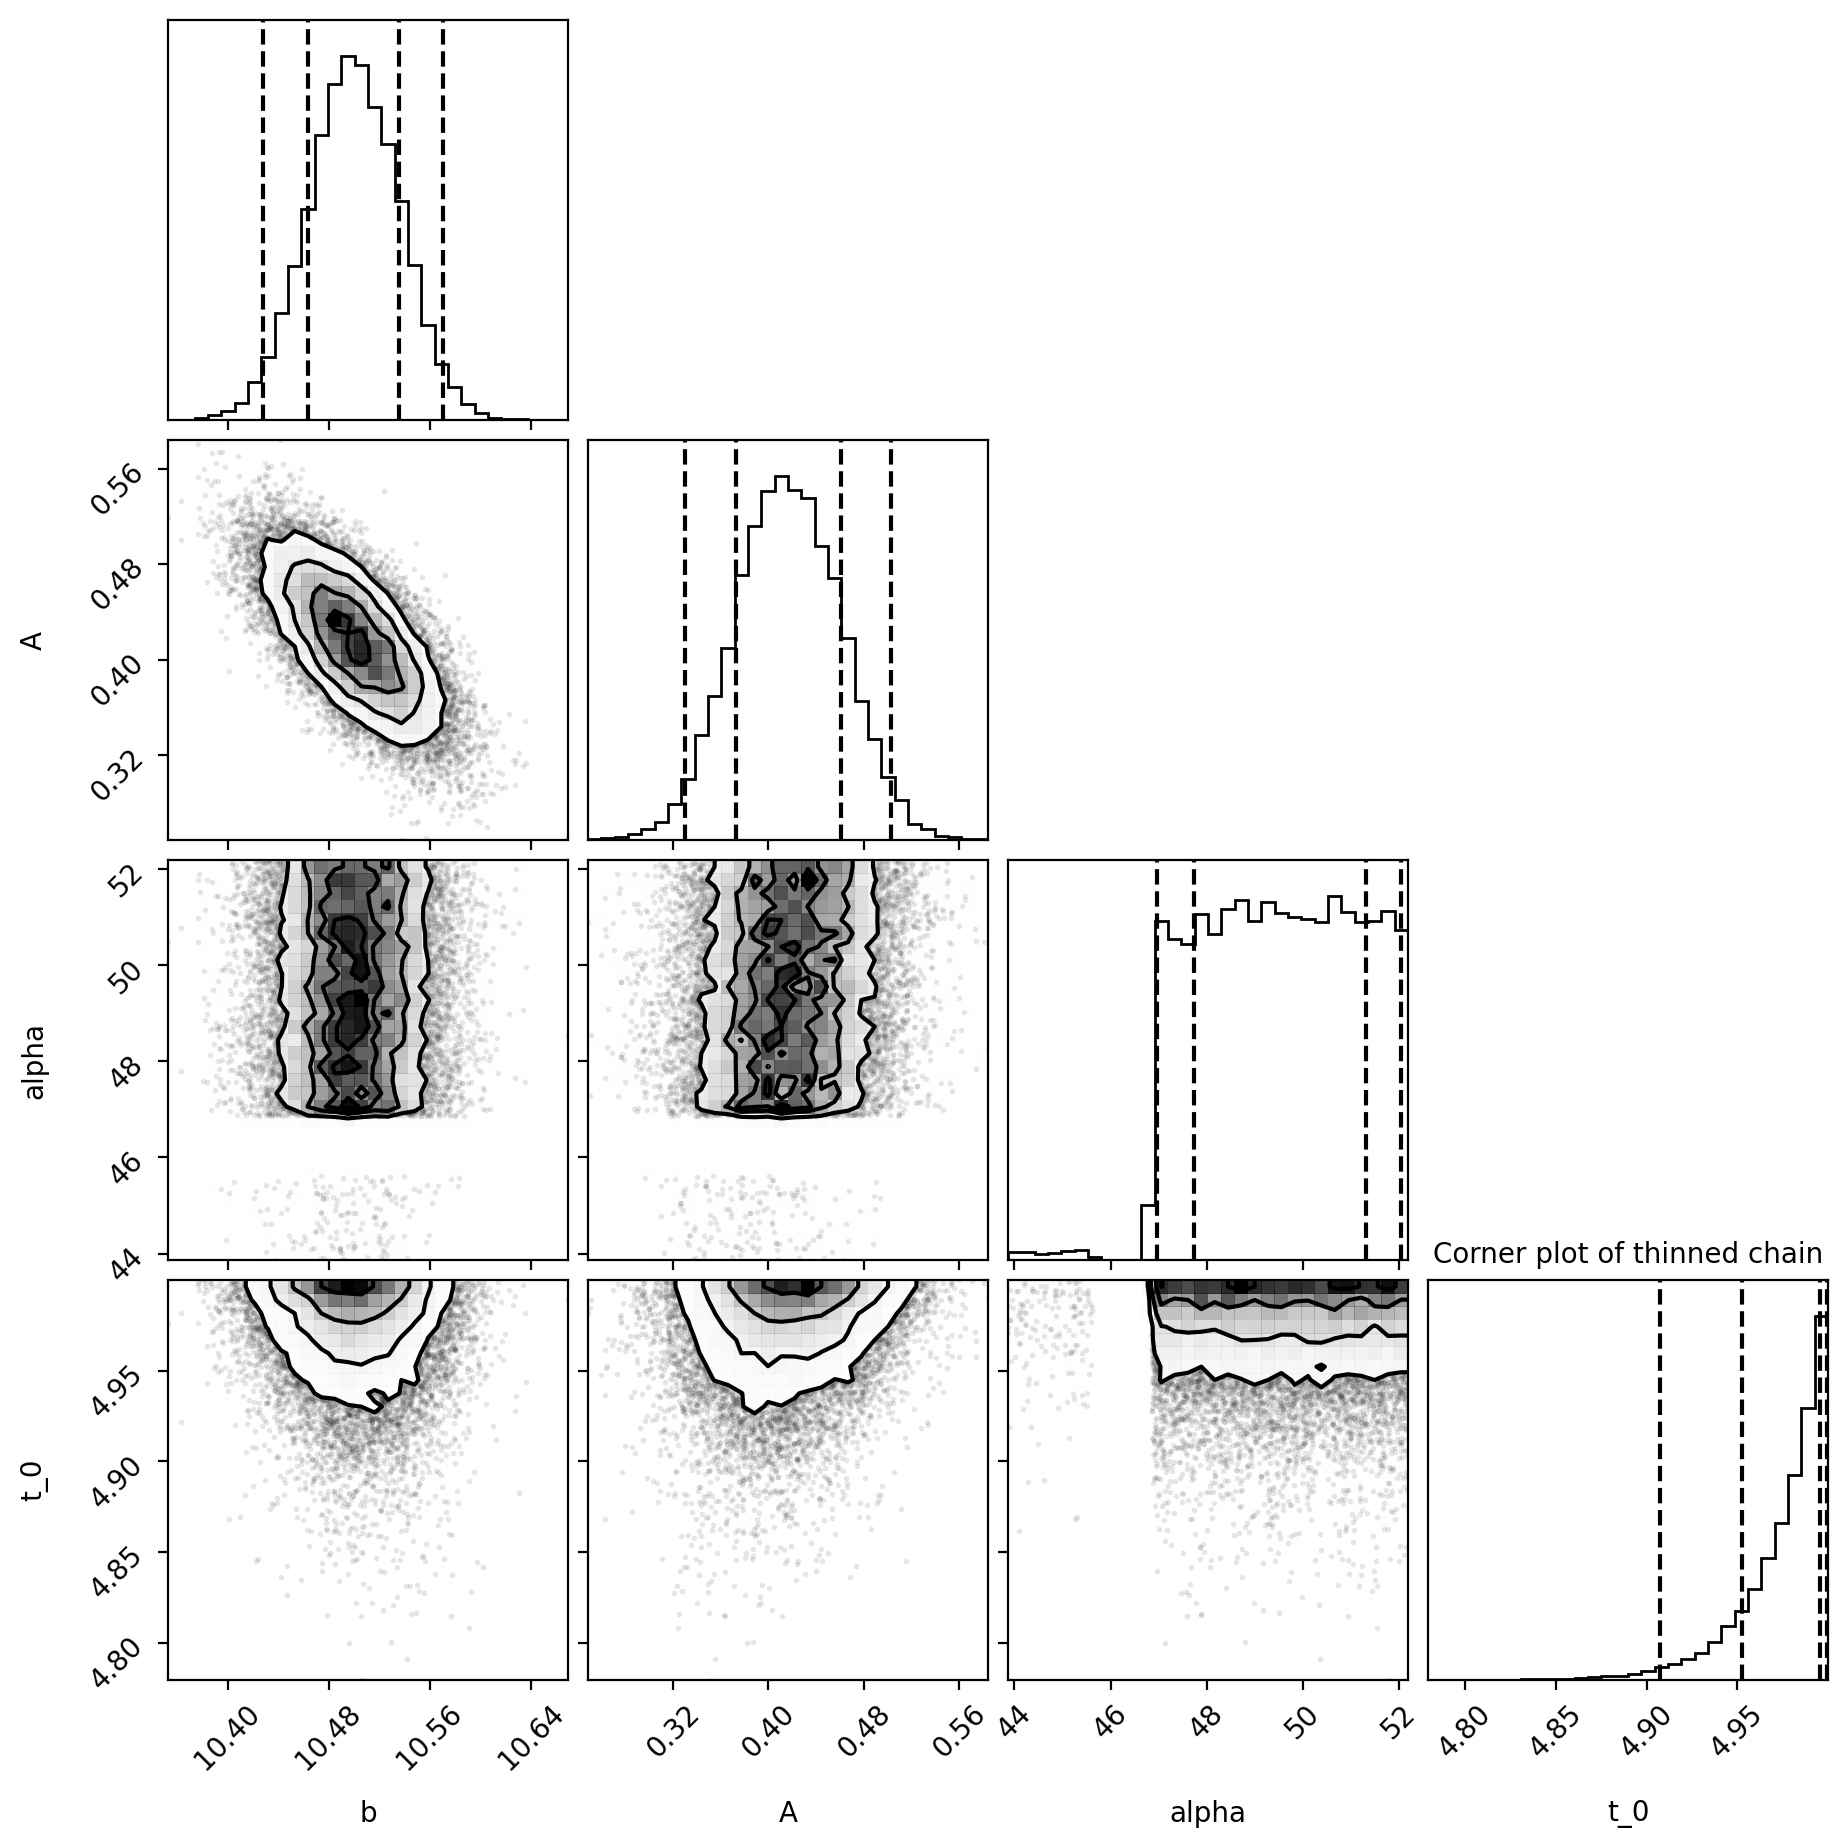

In [254]:
#corner plot of thinned chain

#plot with labels and 68%, 95% credible regions
fig = corner.corner(data=thinned_chains,labels=['b', 'A', 'alpha', 't_0'], plot_contours=True, bins=30, quantiles=[0.16, 0.84, 0.025, 0.975])
plt.title("Corner plot of thinned chain", fontsize=10)
plt.show()

#### 1.6

6) Now choose $100$ samples randomly from your burned, thinned chain and plot the $100$ corresponding burst time-series on a figure along with the original data. You may want to choose a transparency for these $100$ burst curves that allows you to see everything nicely. These are showing the posterior spread of model solutions that are consistent with the data.

In [255]:
#100 samples from burned, thinned chain
random_samples = thinned_chains[np.random.choice(len(thinned_chains), size=100, replace=False)]
print(len(random_samples))
print(random_samples)

100
[[10.47725533  0.46327995 49.90249476  4.99806935]
 [10.52727173  0.40624082 47.56713052  4.93644811]
 [10.47975965  0.40323141 50.02358893  4.97538345]
 [10.55888143  0.39211044 50.97019495  4.95827613]
 [10.4410608   0.53170458 50.20673243  4.98304516]
 [10.50247287  0.38568298 50.71535319  4.92521131]
 [10.56237881  0.34367801 47.98215492  4.98025947]
 [10.52767788  0.32881264 51.46763645  4.92807011]
 [10.51173727  0.40110316 48.90604     4.94626385]
 [10.49319269  0.46224887 51.65164731  4.99458314]
 [10.44743045  0.52228589 51.27940869  4.99458248]
 [10.44253954  0.45709595 51.62856847  4.989668  ]
 [10.54111438  0.43916227 47.20286445  4.98892272]
 [10.49647926  0.43043658 52.06662385  4.99889021]
 [10.53449155  0.38492873 50.87531788  4.967846  ]
 [10.49160009  0.48333567 51.0184025   4.92375366]
 [10.56023443  0.35379015 47.03132979  4.99063469]
 [10.51477014  0.44612906 51.09771981  4.96915351]
 [10.45639962  0.44908727 49.57037888  4.99473083]
 [10.48697926  0.43570082 5

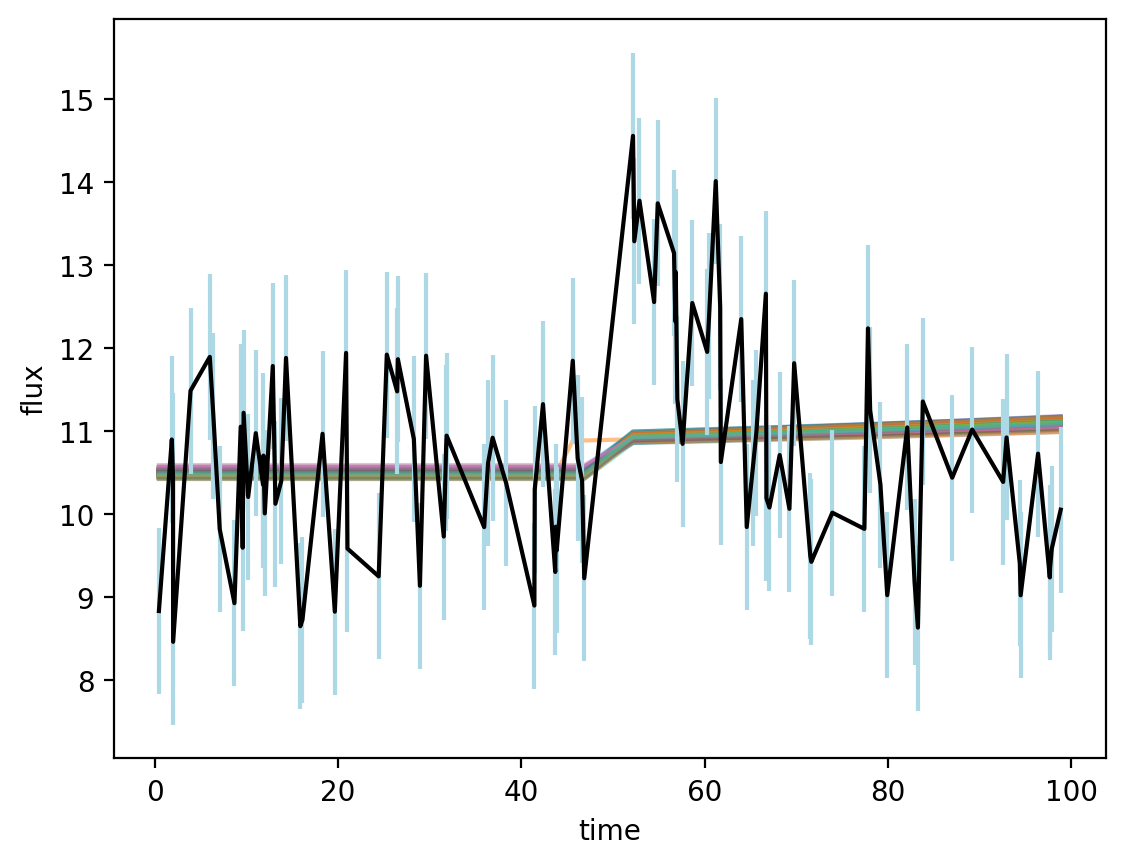

In [259]:
#plot burst time-series
#pass the samples as parameters of burst model
for i in range(len(random_samples)):
    time_series = burst_model(X = random_samples[i], t=time)
    plt.plot(time, time_series, alpha=0.5)

#original data
plt.errorbar(time, flux, yerr=uncertainties,color='black', ecolor='lightblue')

plt.xlabel('time')
plt.ylabel('flux')

plt.show()


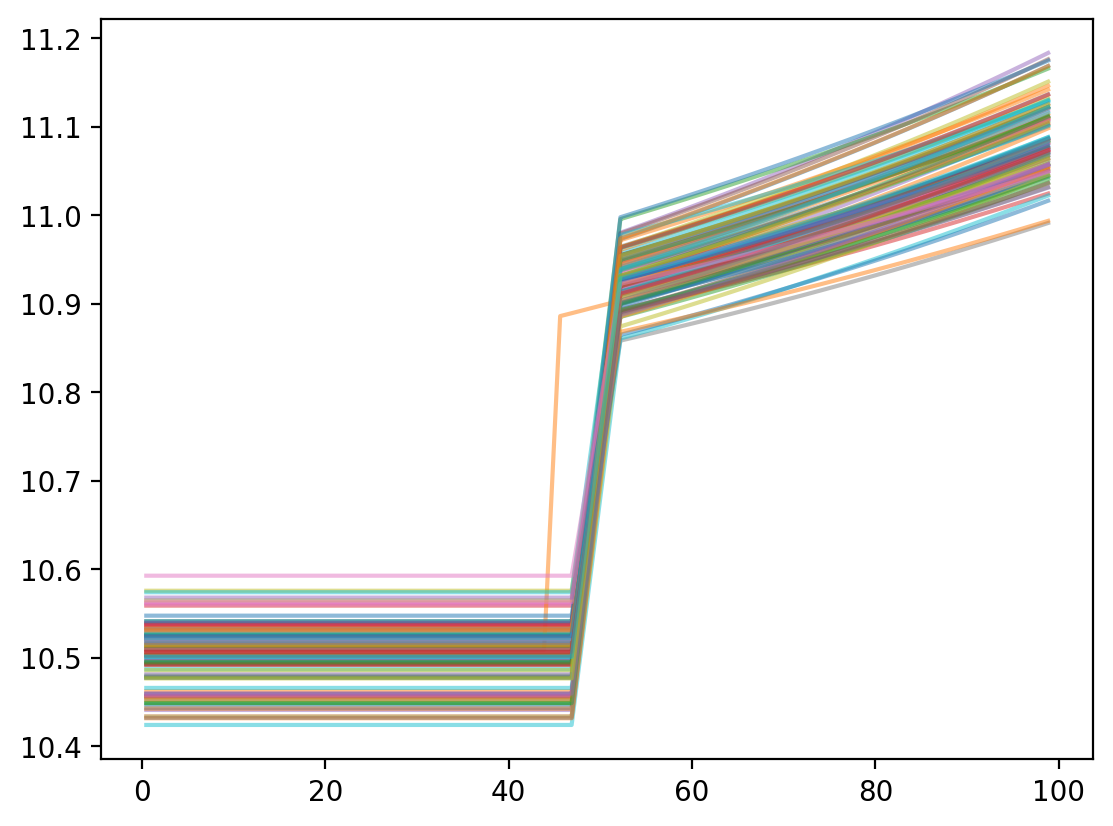

In [258]:
#plotting just the burst time series
for i in range(len(random_samples)):
    time_series = burst_model(X = random_samples[i], t=time)
    plt.plot(time, time_series, alpha=0.5)

This plot doesn't look that great, but the burst time-series does have a slight peak around where the original data peaks. I checked that my burst model works correctly earlier, so I'm unsure of what the true issue behind this plot is.
I noticed that the 'A' values in random_samples seem really small, and given that A is the burst amplitude, this could be where the problem lies

#### 1.7

7) Another possible model that may explain the data is a Gaussian profile described by:

$y = b + A\exp[-(t-t_0)^2 / 2\sigma_W^2]$

The priors for this model are the same as above for the equivalent parameters, and with $\ln\sigma_W\in\mathrm{Uniform}[-2,2]$. Following the examples from `Lecture 12` and from relevant web tutorials/documentation, use one of the nested sampling packages (`dynesty` or `UltraNest`) to compute the Bayesian evidence for this Gaussian model, and for the original burst model. Compute the Bayes factor, and state which model is the favored description of the data. *Hint: Be careful with how you transform your parameter space into a unit hypercube for the nested sampling priors. An appropriate check on whether you have done things correctly is that the posterior samples you get from the burst analysis here should give an equivalent corner plot to the MCMC you did above.*

<span style="color:blue">Bayesian evidence for the Gaussian model</span>

In [343]:
import dynesty 
ndim = 4

#define gaussian model
def gaussian_profile(g,t):
    b, A, t_0, sigma = g
    return b + A*np.exp(-(t - t_0)**2 / (2 * (np.exp(sigma)**2)))

#define log likelihood for the gaussian model
def log_likelihood(g):
    b, A, t_0, sigma = g
    predict = gaussian_profile(g, t)
    gauss_logL = np.sum(scipy.stats.norm.logpdf(data, loc=predict, scale=uncertainties))
    return gauss_logL

#define log prior: Transforms samples `u` drawn from the unit cube
def gauss_priors(u):
    b = 50*u[0]  #uniform prior from 0 to 50 
    A = 50*u[1] #uniform prior from 0 to 50 
    t_0 = 100 *u[2] #uniform prior from 0 to 100
    ln_sigma = 4 * u[3] - 2 #ln_sigma is uniform (-2,2)
    return np.array([b,A,t_0,ln_sigma])


#bayesian evidence for the gaussian model 
sampler_gauss = dynesty.NestedSampler(log_likelihood, gauss_priors, ndim, bootstrap=0)
sampler_gauss.run_nested()
results_gauss = sampler_gauss.results


print(results_gauss)

 

iter: 3 | bound: 0 | nc: 1 | ncall: 503 | eff(%):  0.596 | loglstar:   -inf < -90996.222 <    inf | logz: -91003.136 +/-  0.118 | dlogz: 98669.804 >  0.509                                           

iter: 7999 | +500 | bound: 46 | nc: 1 | ncall: 52040 | eff(%): 16.490 | loglstar:   -inf < -144.317 <    inf | logz: -159.588 +/-  0.174 | dlogz:  0.001 >  0.509                                     

         nlive: 500
         niter: 7999
         ncall: array([1, 1, 1, ..., 1, 1, 1])
           eff: 16.490104772991852
       samples: array([[47.88199918, 45.06763421, 53.02233361,  1.82477601],
       [49.55903095, 43.59420578, 71.46979173,  1.44879694],
       [46.65645129, 42.47290481,  9.45250843,  1.09012231],
       ...,
       [10.28397639,  2.69085795, 55.83039374,  1.73667653],
       [10.33134686,  2.87060952, 55.19993635,  1.64324563],
       [10.29331045,  2.80065867, 55.51642404,  1.66658153]])
          blob: array([None, None, None, ..., None, None, None], dtype=object)
    samples_id: array([486, 244, 366, ...,   2,  40,  16])
    samples_it: array([   0,    0,    0, ..., 7884, 7671, 7817])
     samples_u: array([[0.95763998, 0.90135268, 0.53022334, 0.956194  ],
       [0.99118062, 0.87188412, 0.71469792, 0.86219924],
       [0.93312903, 0.8494581 , 0.09452508, 0.77253058],
       ...,
       [0.20567953, 0.05381716, 0.55830394, 0.93416913],
       [0.20662694, 0.0

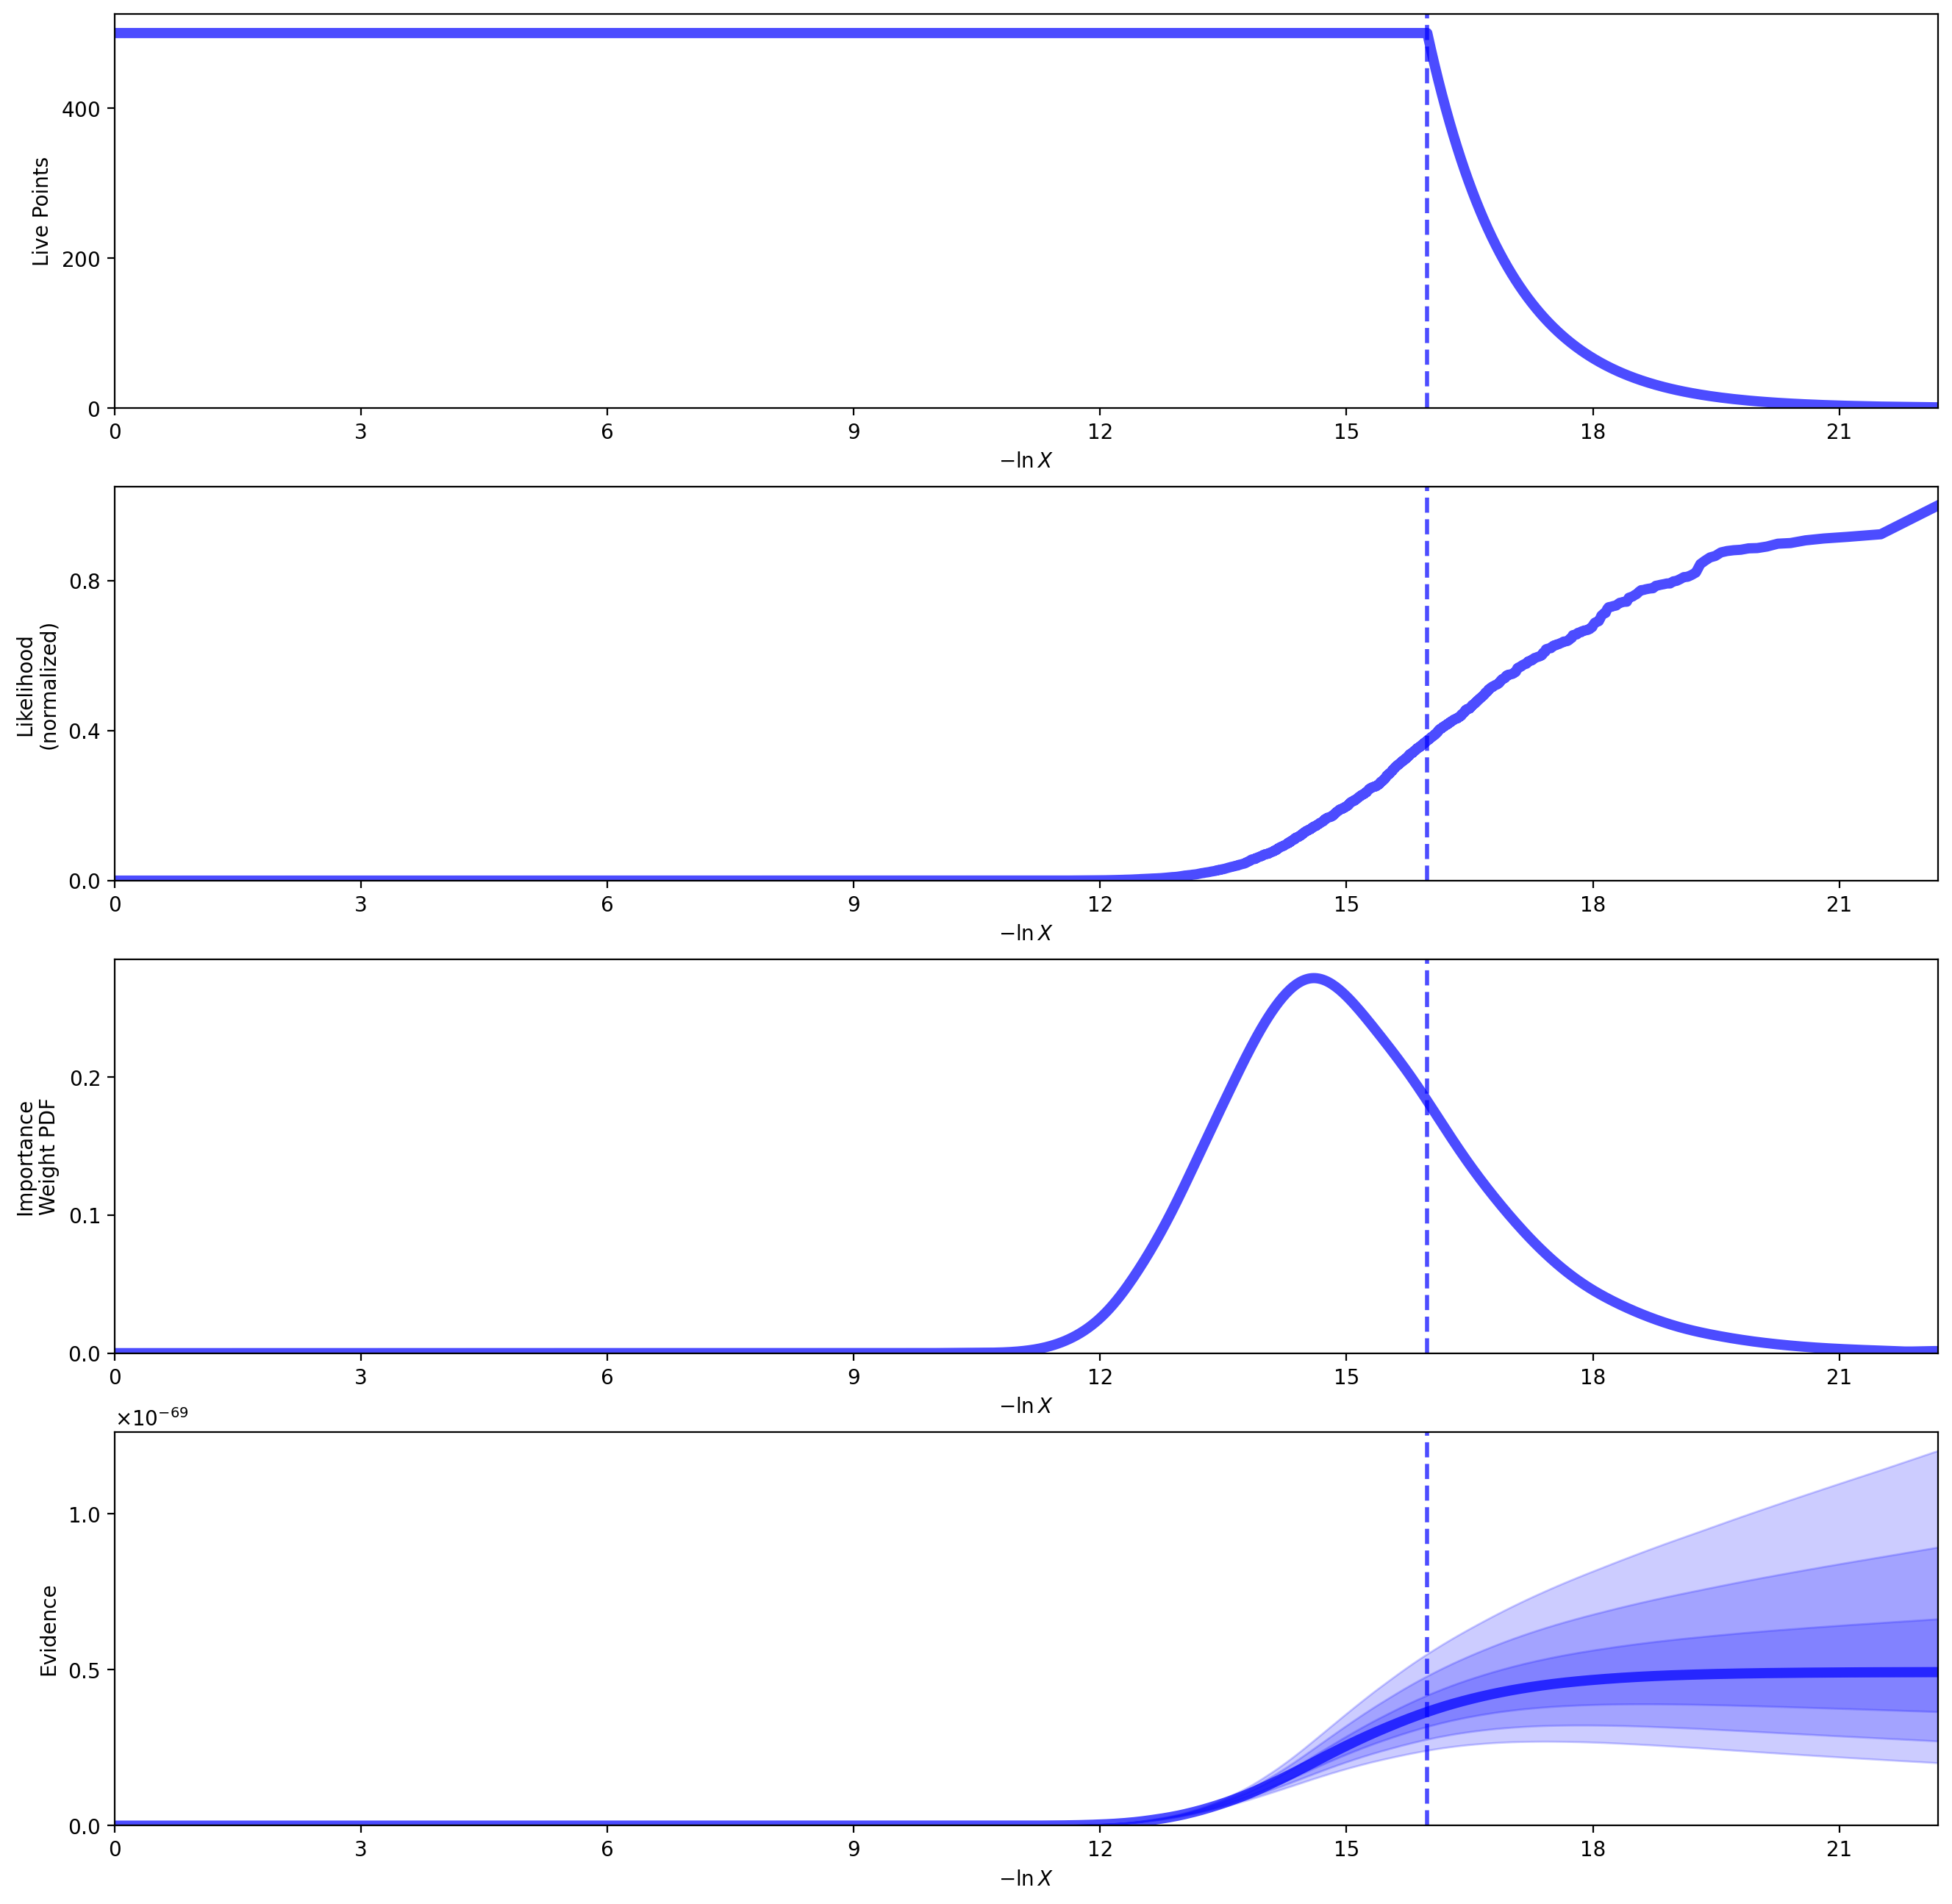

In [344]:
#plots
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results_gauss)


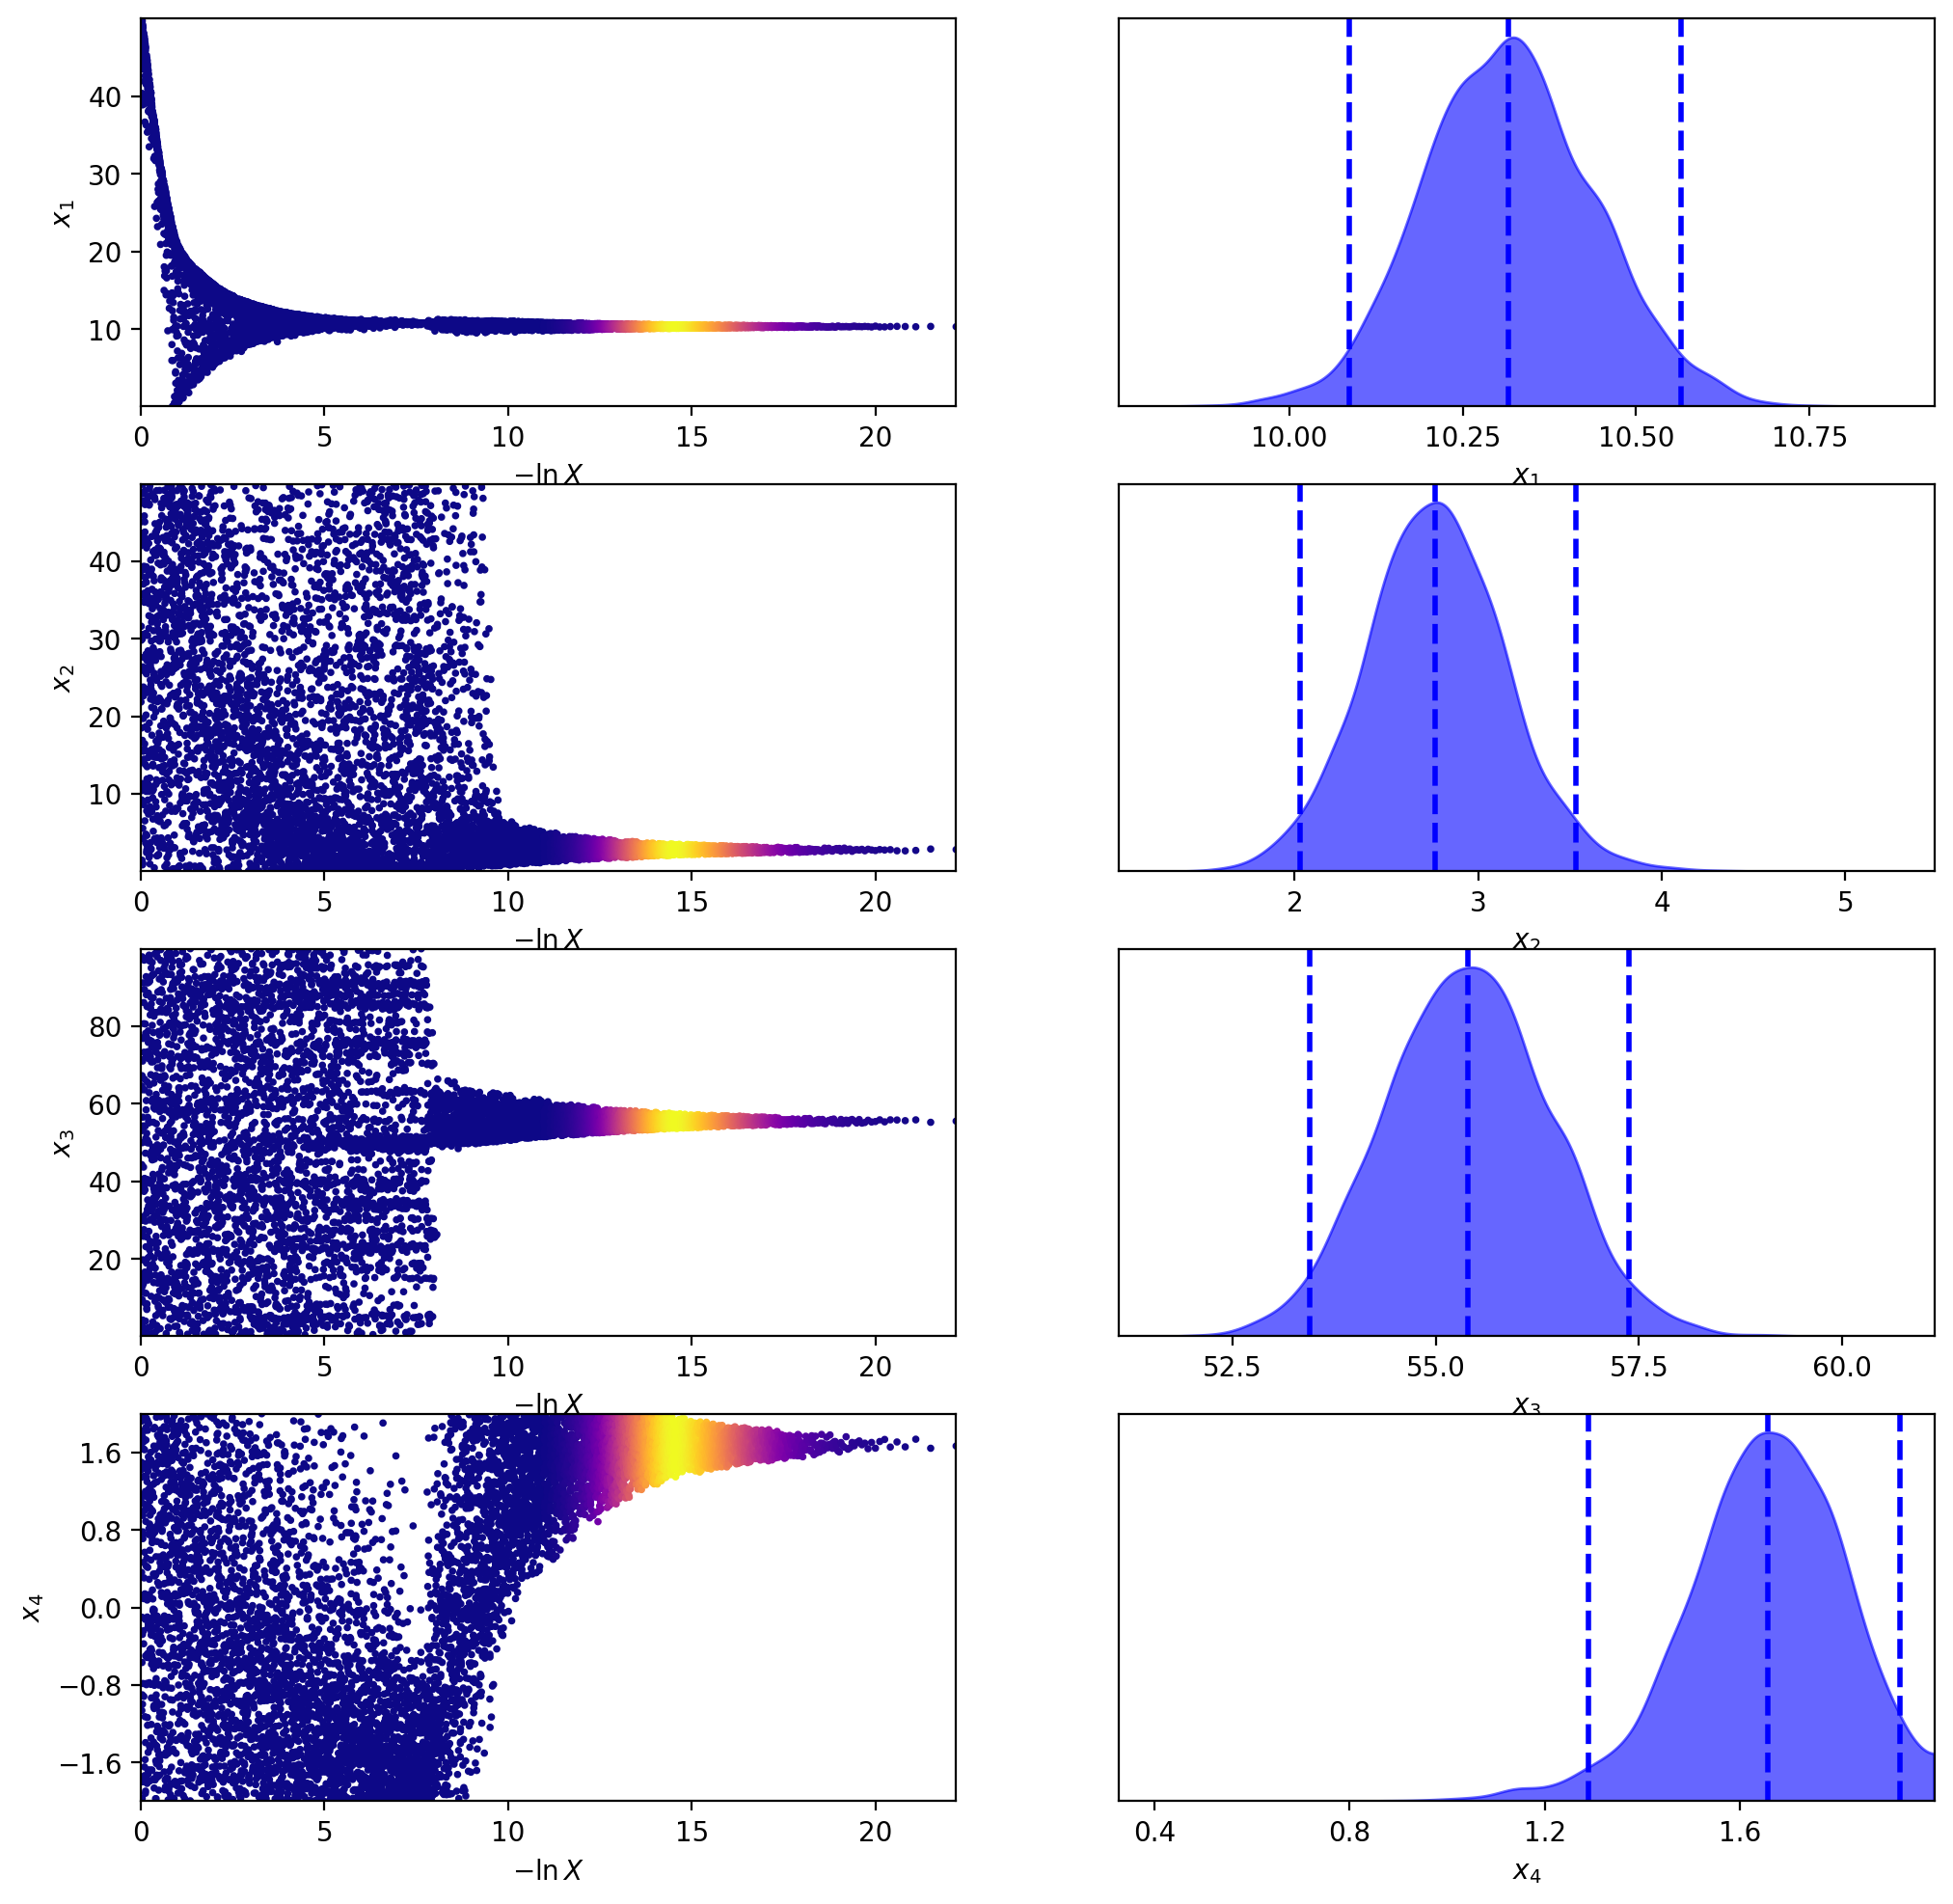

In [345]:
tfig, taxes = dyplot.traceplot(results_gauss)
#here, x1=b, x2=A, x3=t_0, x4=ln_sigma

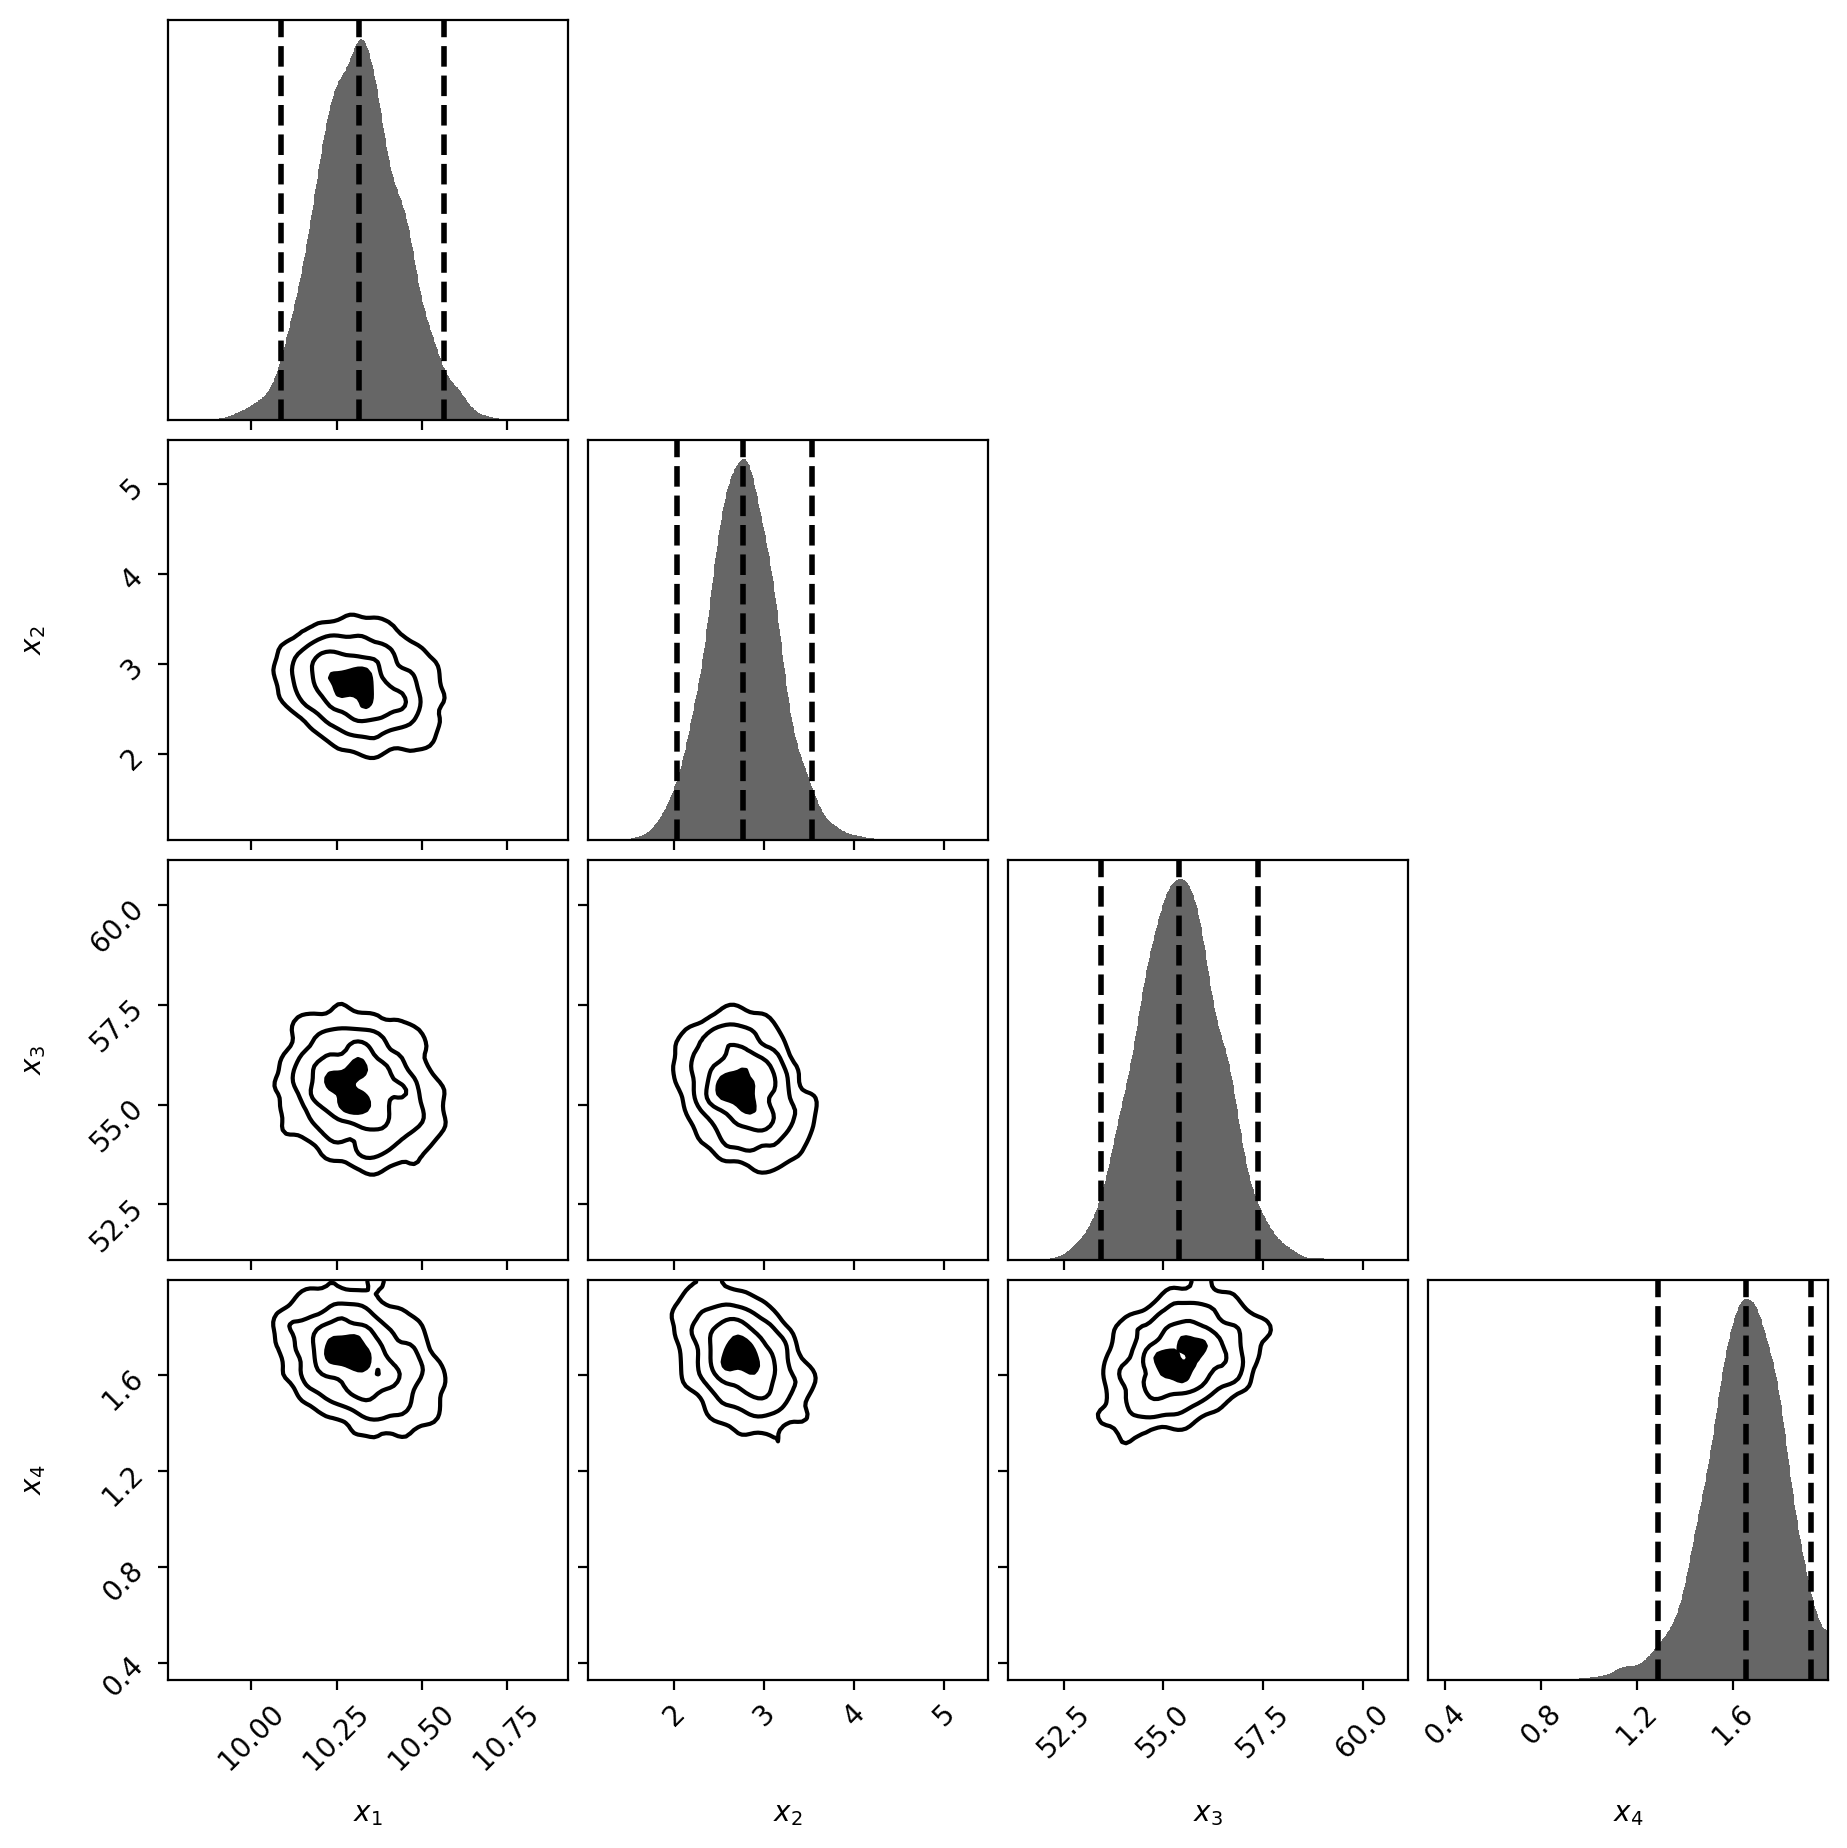

In [346]:
#corner plot
cfig, caxes = dyplot.cornerplot(results_gauss)

<span style="color:blue">Bayesian evidence for the burst model</span>

In [368]:
import dynesty 
ndim = 4

#define burst model
def burst_model(X, t):
    b, A, t_0, alpha = X
    y_predict = np.zeros_like(t)
    for i, t_i in enumerate(t):
        if t_i < t_0:
            y_predict[i] = b
        else:
            y_predict[i] = b + A * np.exp(np.exp(-alpha) * (t_i - t_0))
    return y_predict

#define logL of the burst model (same as 1.2)     
def logL(X, model=burst_model):
    b, A, t_0, alpha = X
    y_predict = model([b, A, t_0, alpha], t)
    data2 = y_predict - data
    log_pdf_L = ((data2/uncertainties)**2) #from lecture 6, lnL = constant - 0.5chi^2 for gaussian uncertainties
    return -0.5 * np.sum(log_pdf_L)

#define log prior: Transforms samples `u` drawn from the unit cube
def burst_priors(u):
    b = 50*u[0]  #uniform prior from 0 to 50 
    A = 50*u[1] #uniform prior from 0 to 50 
    t_0 = 100 *u[2] #uniform prior from 0 to 100
    ln_alpha = 10 * u[3] - 5 #ln_alpha is uniform (-5,5)
    return np.array([b,A,t_0,ln_alpha])
    


#bayesian evidence for the gaussian model 
sampler_burst = dynesty.NestedSampler(logL, burst_priors, ndim)
sampler_burst.run_nested()
results_burst = sampler_burst.results


print(results_burst)

/var/folders/pb/dh7ptllx07x6kqjhnzw594yr0000gn/T/ipykernel_54162/538065796.py:12: RuntimeWarning: overflow encountered in exp
  y_predict[i] = b + A * np.exp(np.exp(-alpha) * (t_i - t_0))
/var/folders/pb/dh7ptllx07x6kqjhnzw594yr0000gn/T/ipykernel_54162/538065796.py:20: RuntimeWarning: overflow encountered in square
  log_pdf_L = ((data2/uncertainties)**2) #from lecture 6, lnL = constant - 0.5chi^2 for gaussian uncertainties
/var/folders/pb/dh7ptllx07x6kqjhnzw594yr0000gn/T/ipykernel_54162/538065796.py:12: RuntimeWarning: overflow encountered in scalar multiply
  y_predict[i] = b + A * np.exp(np.exp(-alpha) * (t_i - t_0))
iter: 756 | bound: 0 | nc: 5 | ncall: 2497 | eff(%): 30.276 | loglstar:   -inf < -172937.676 <    inf | logz: -172946.142 +/-    nan | dlogz: 175658.130 >  0.509                                     /Users/toralcm/anaconda3/envs/astr8070/lib/python3.11/site-packages/numpy/core/fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, ax

         nlive: 500
         niter: 6470
         ncall: array([2, 2, 1, ..., 1, 1, 1])
           eff: 9.964830011723329
       samples: array([[14.68365078, 37.88459021, 12.48186084, -3.90731606],
       [12.02398987,  2.82685655, 12.91551656, -4.27949691],
       [34.52865208, 49.16670543, 75.5167273 , -3.10366192],
       ...,
       [10.52734651,  0.33716547, 48.66606318,  4.87748488],
       [10.46685275,  0.49074307, 51.10810127,  4.9369836 ],
       [10.50610321,  0.49061844, 47.93732961,  4.98970979]])
          blob: array([None, None, None, ..., None, None, None], dtype=object)
    samples_id: array([360, 361, 362, ..., 130, 311, 369])
    samples_it: array([   0,    0,    0, ..., 6110, 6073, 5656])
     samples_u: array([[0.29367302, 0.7576918 , 0.12481861, 0.10926839],
       [0.2404798 , 0.05653713, 0.12915517, 0.07205031],
       [0.69057304, 0.98333411, 0.75516727, 0.18963381],
       ...,
       [0.21054693, 0.00674331, 0.48666063, 0.98774849],
       [0.20933706, 0.00

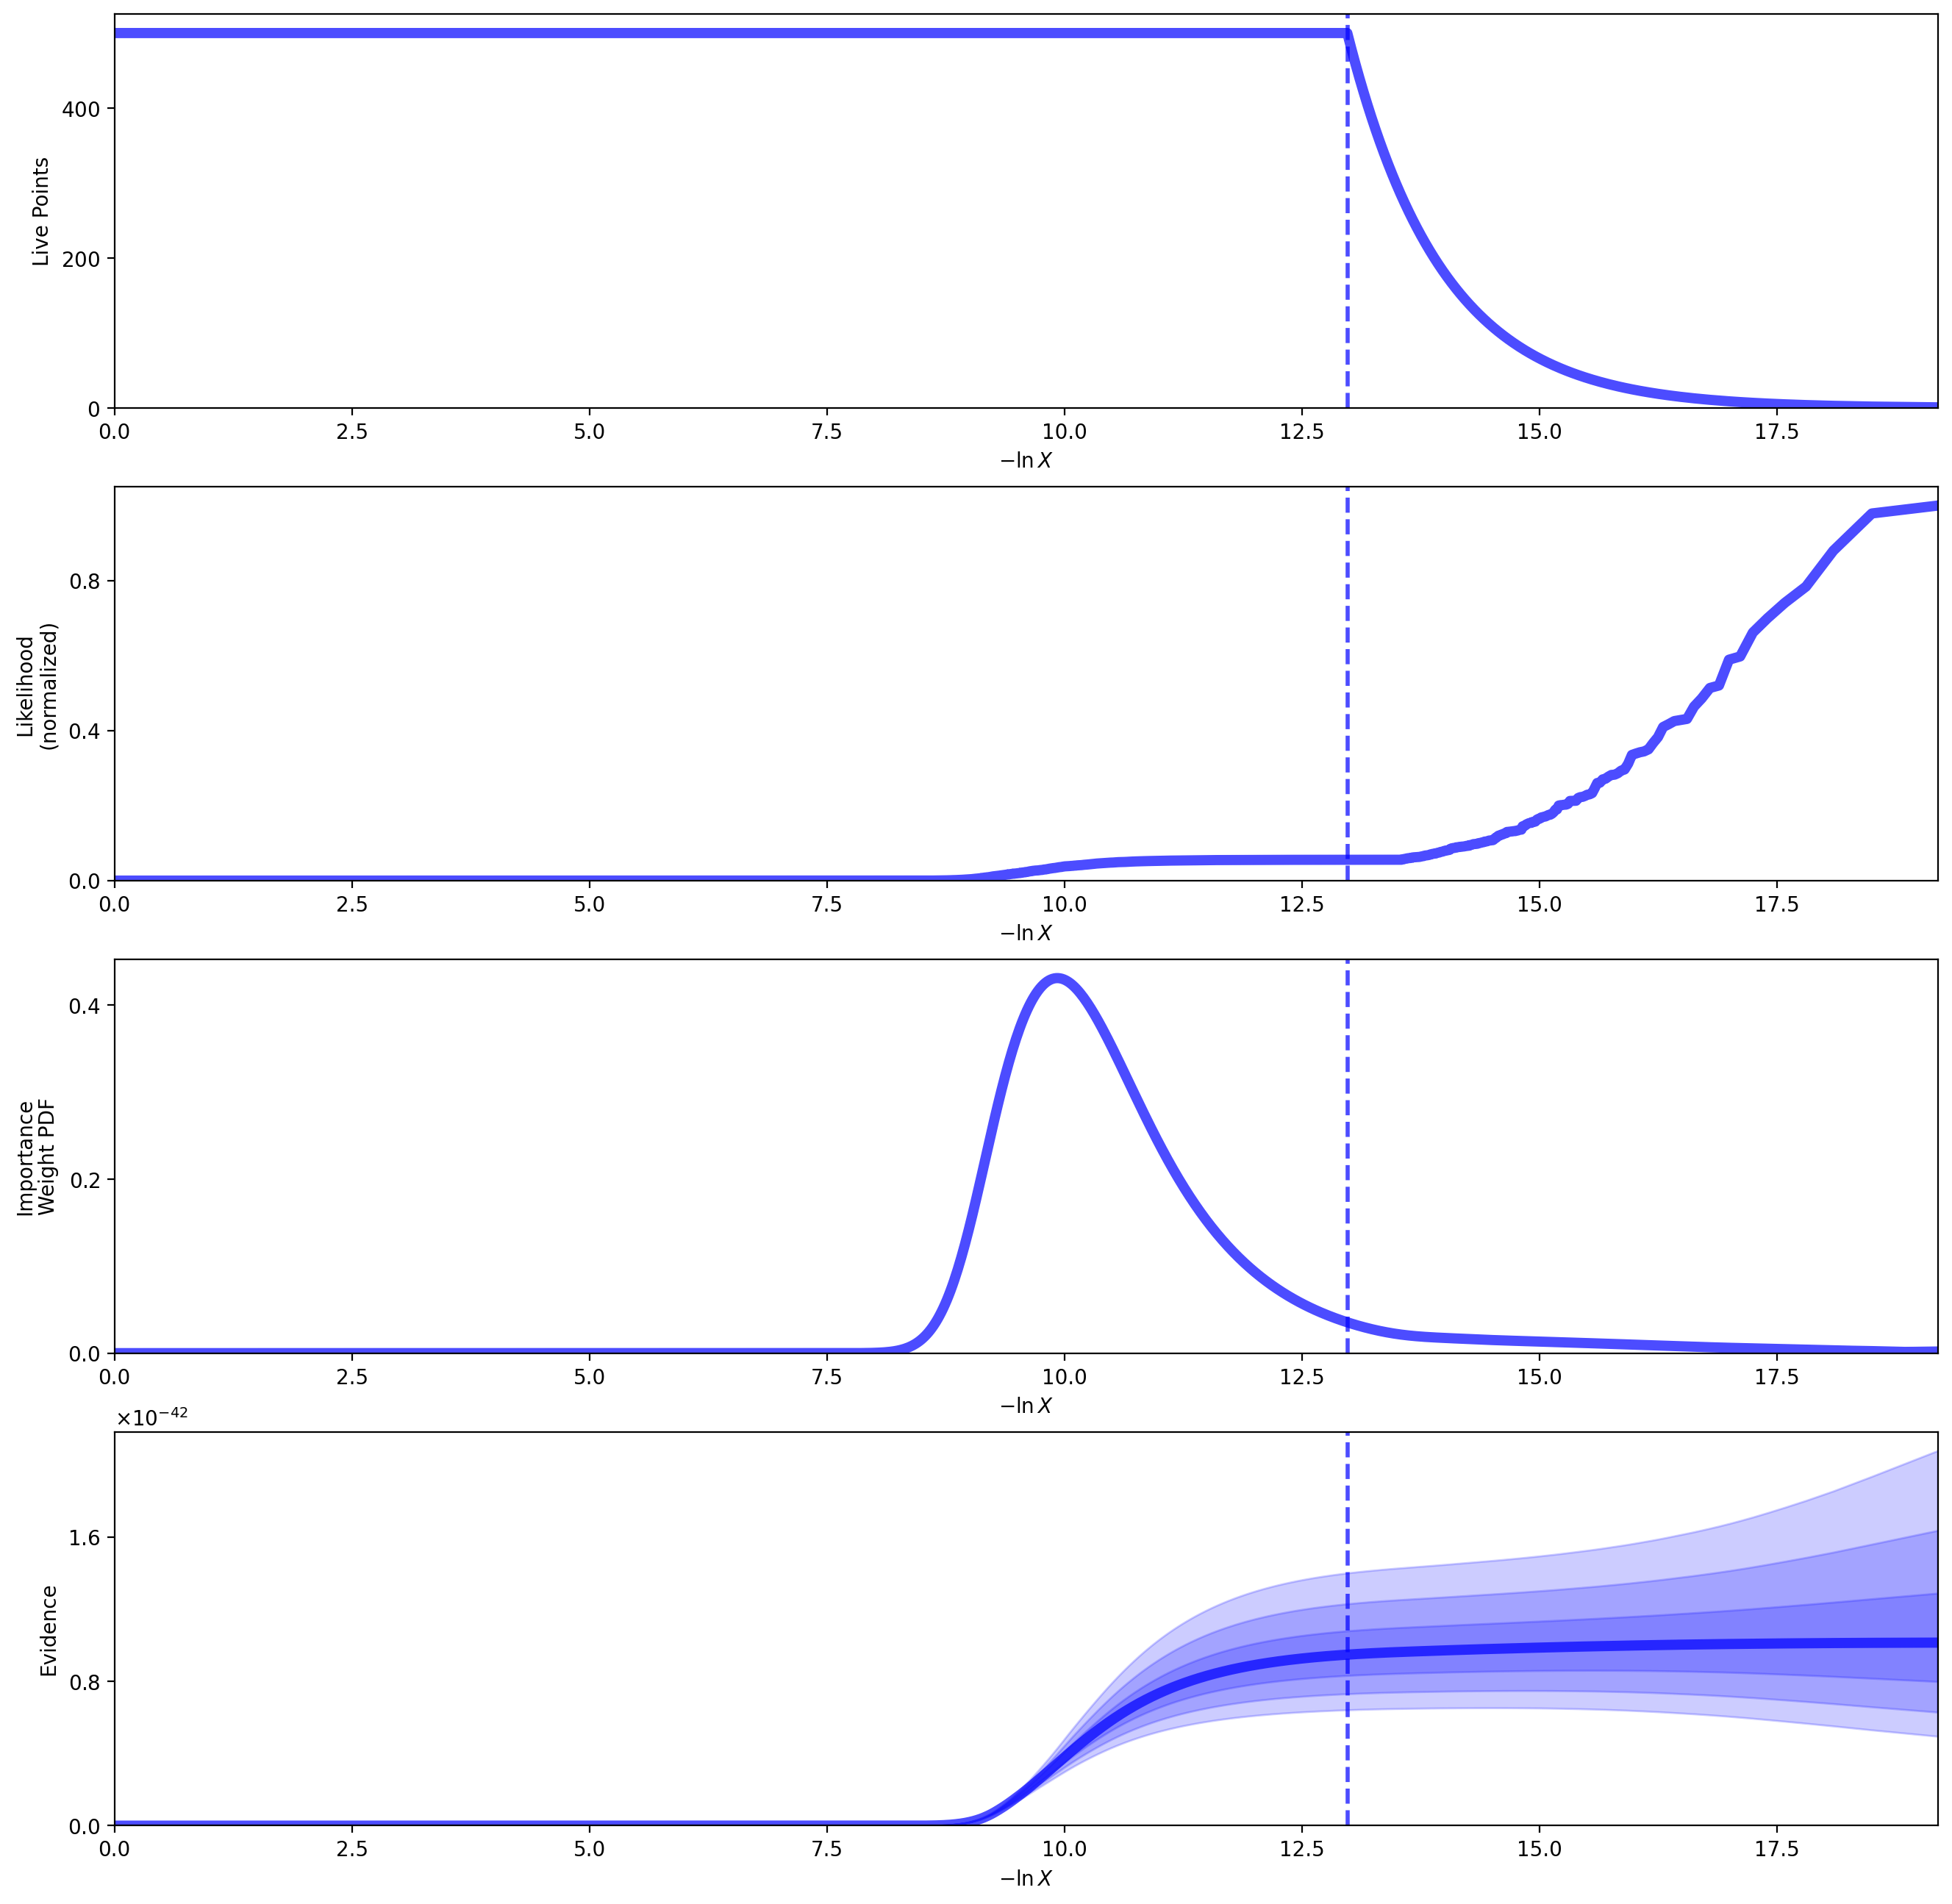

In [369]:
#plots
from dynesty import plotting as dyplot

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results_burst)

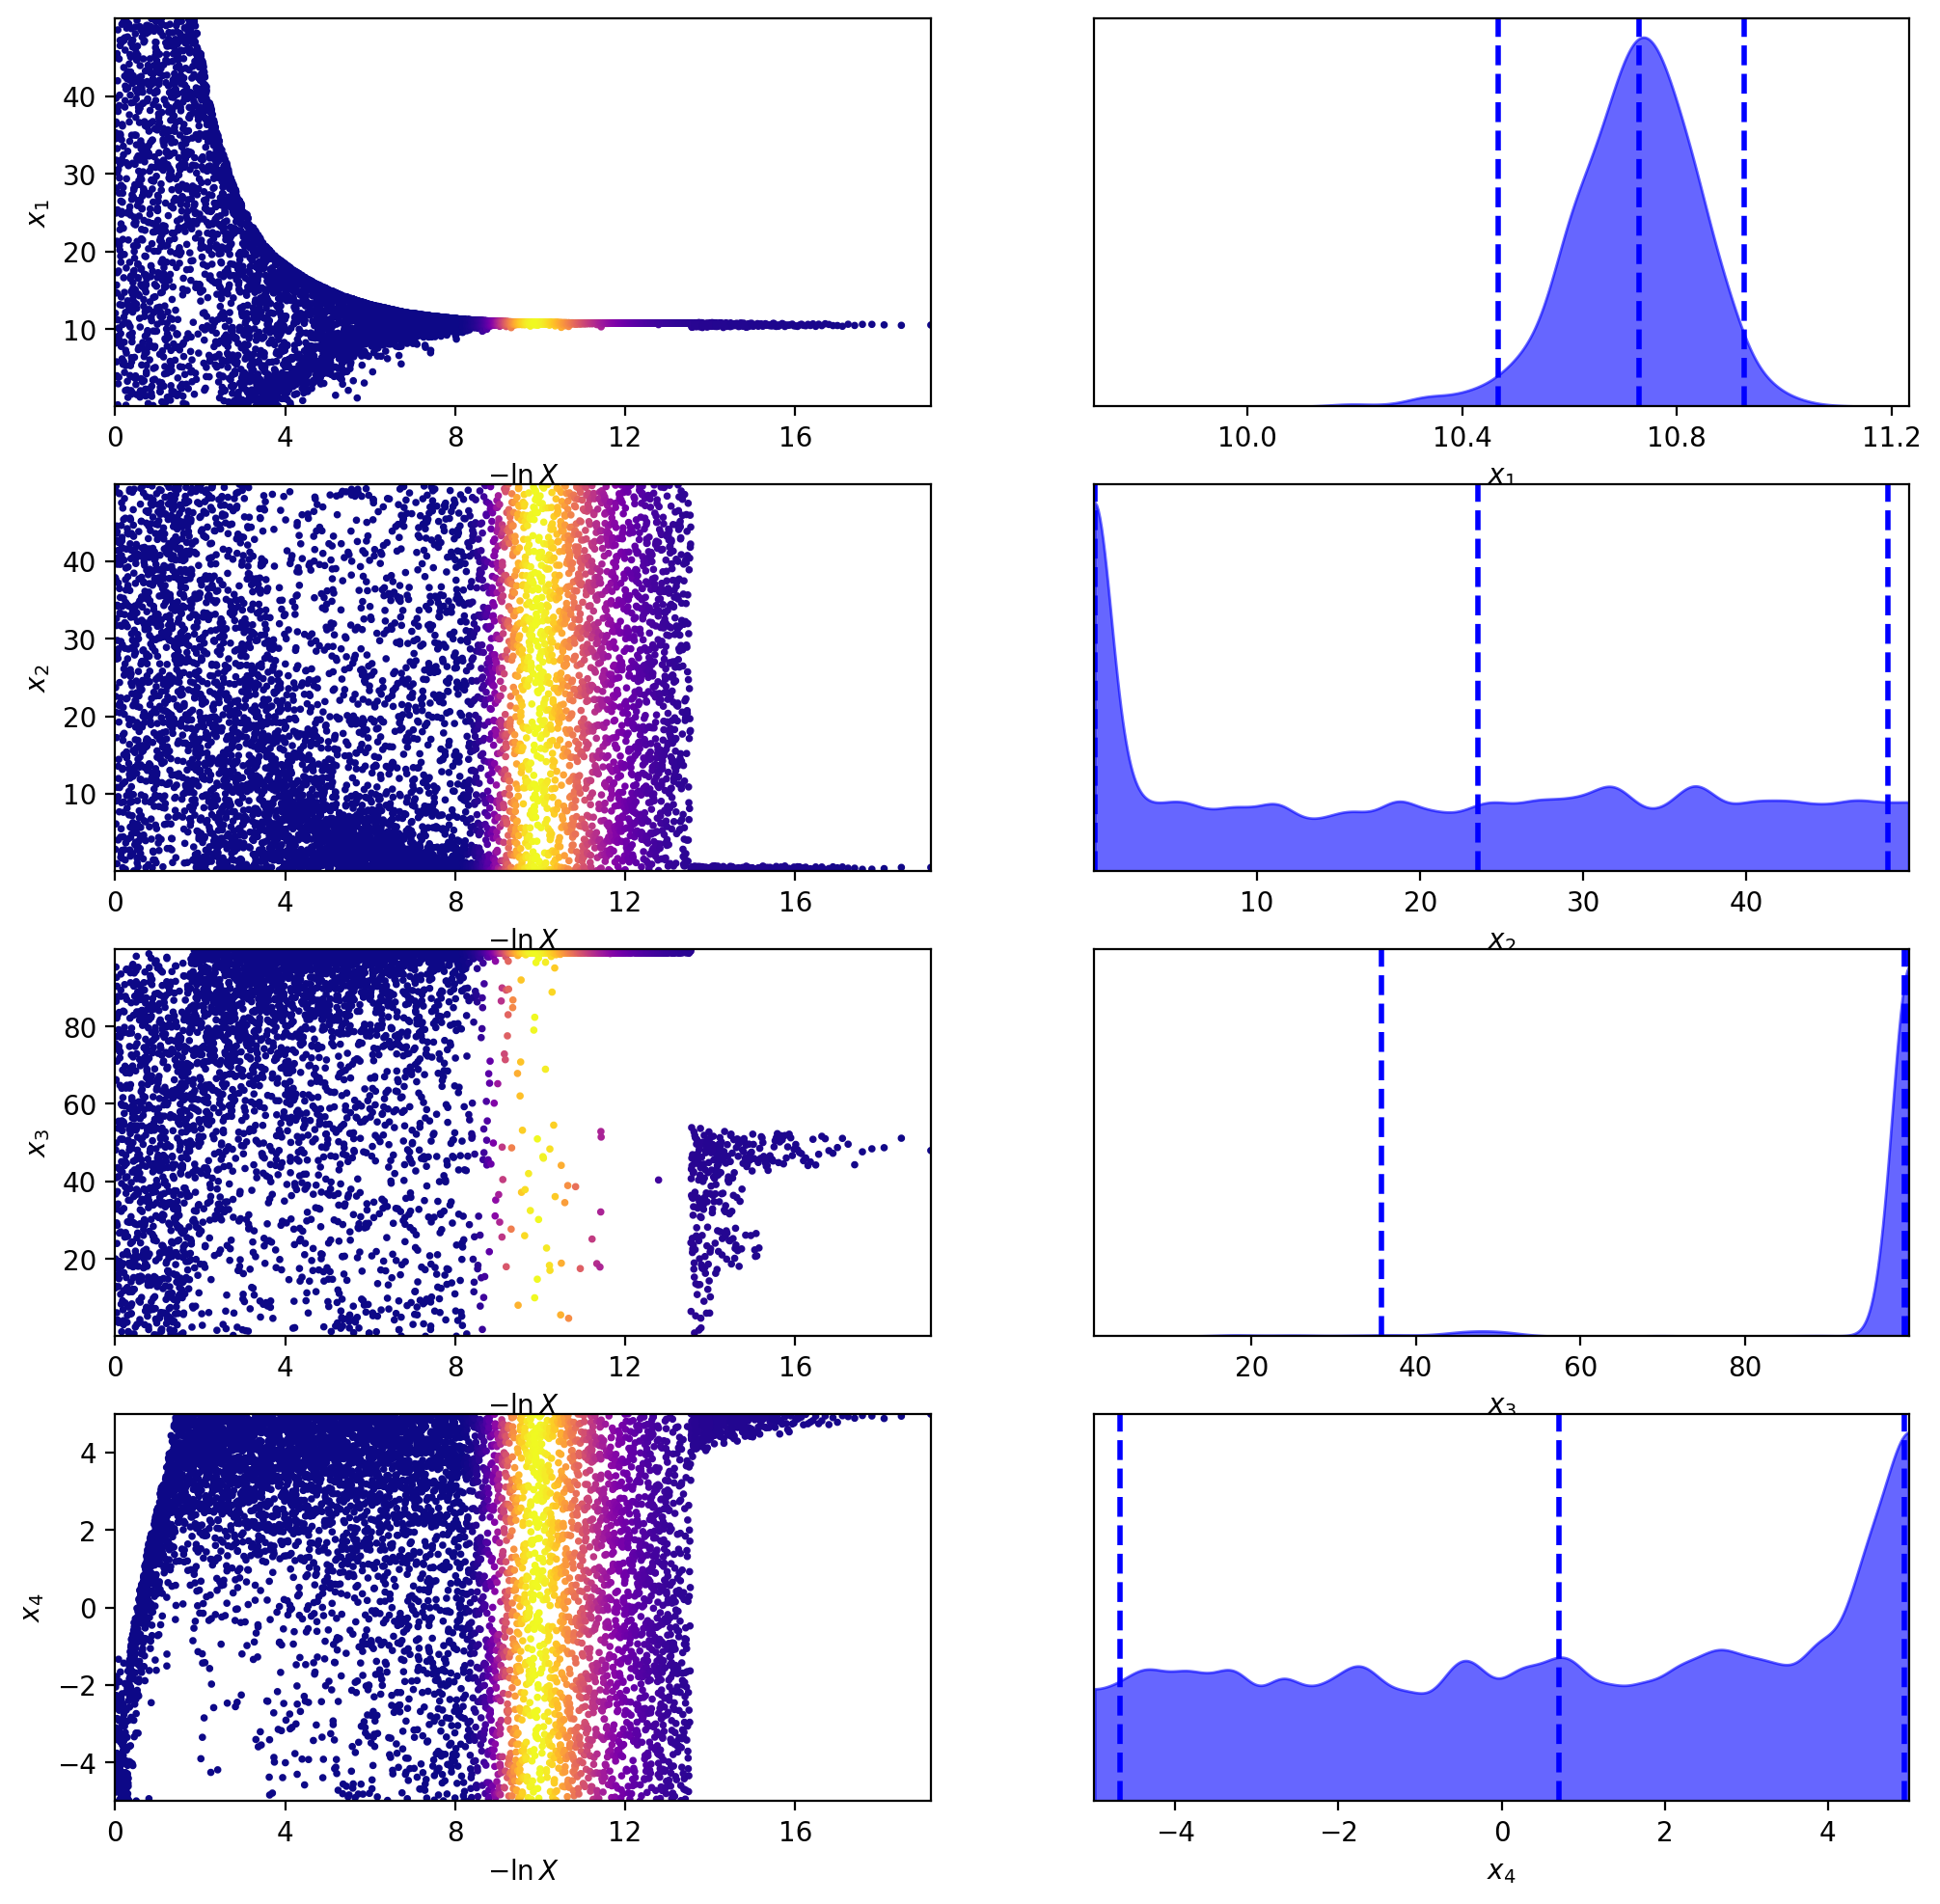

In [370]:
tfig, taxes = dyplot.traceplot(results_burst)
#here, x1=b, x2=A, x3=t_0, x4=ln_sigma

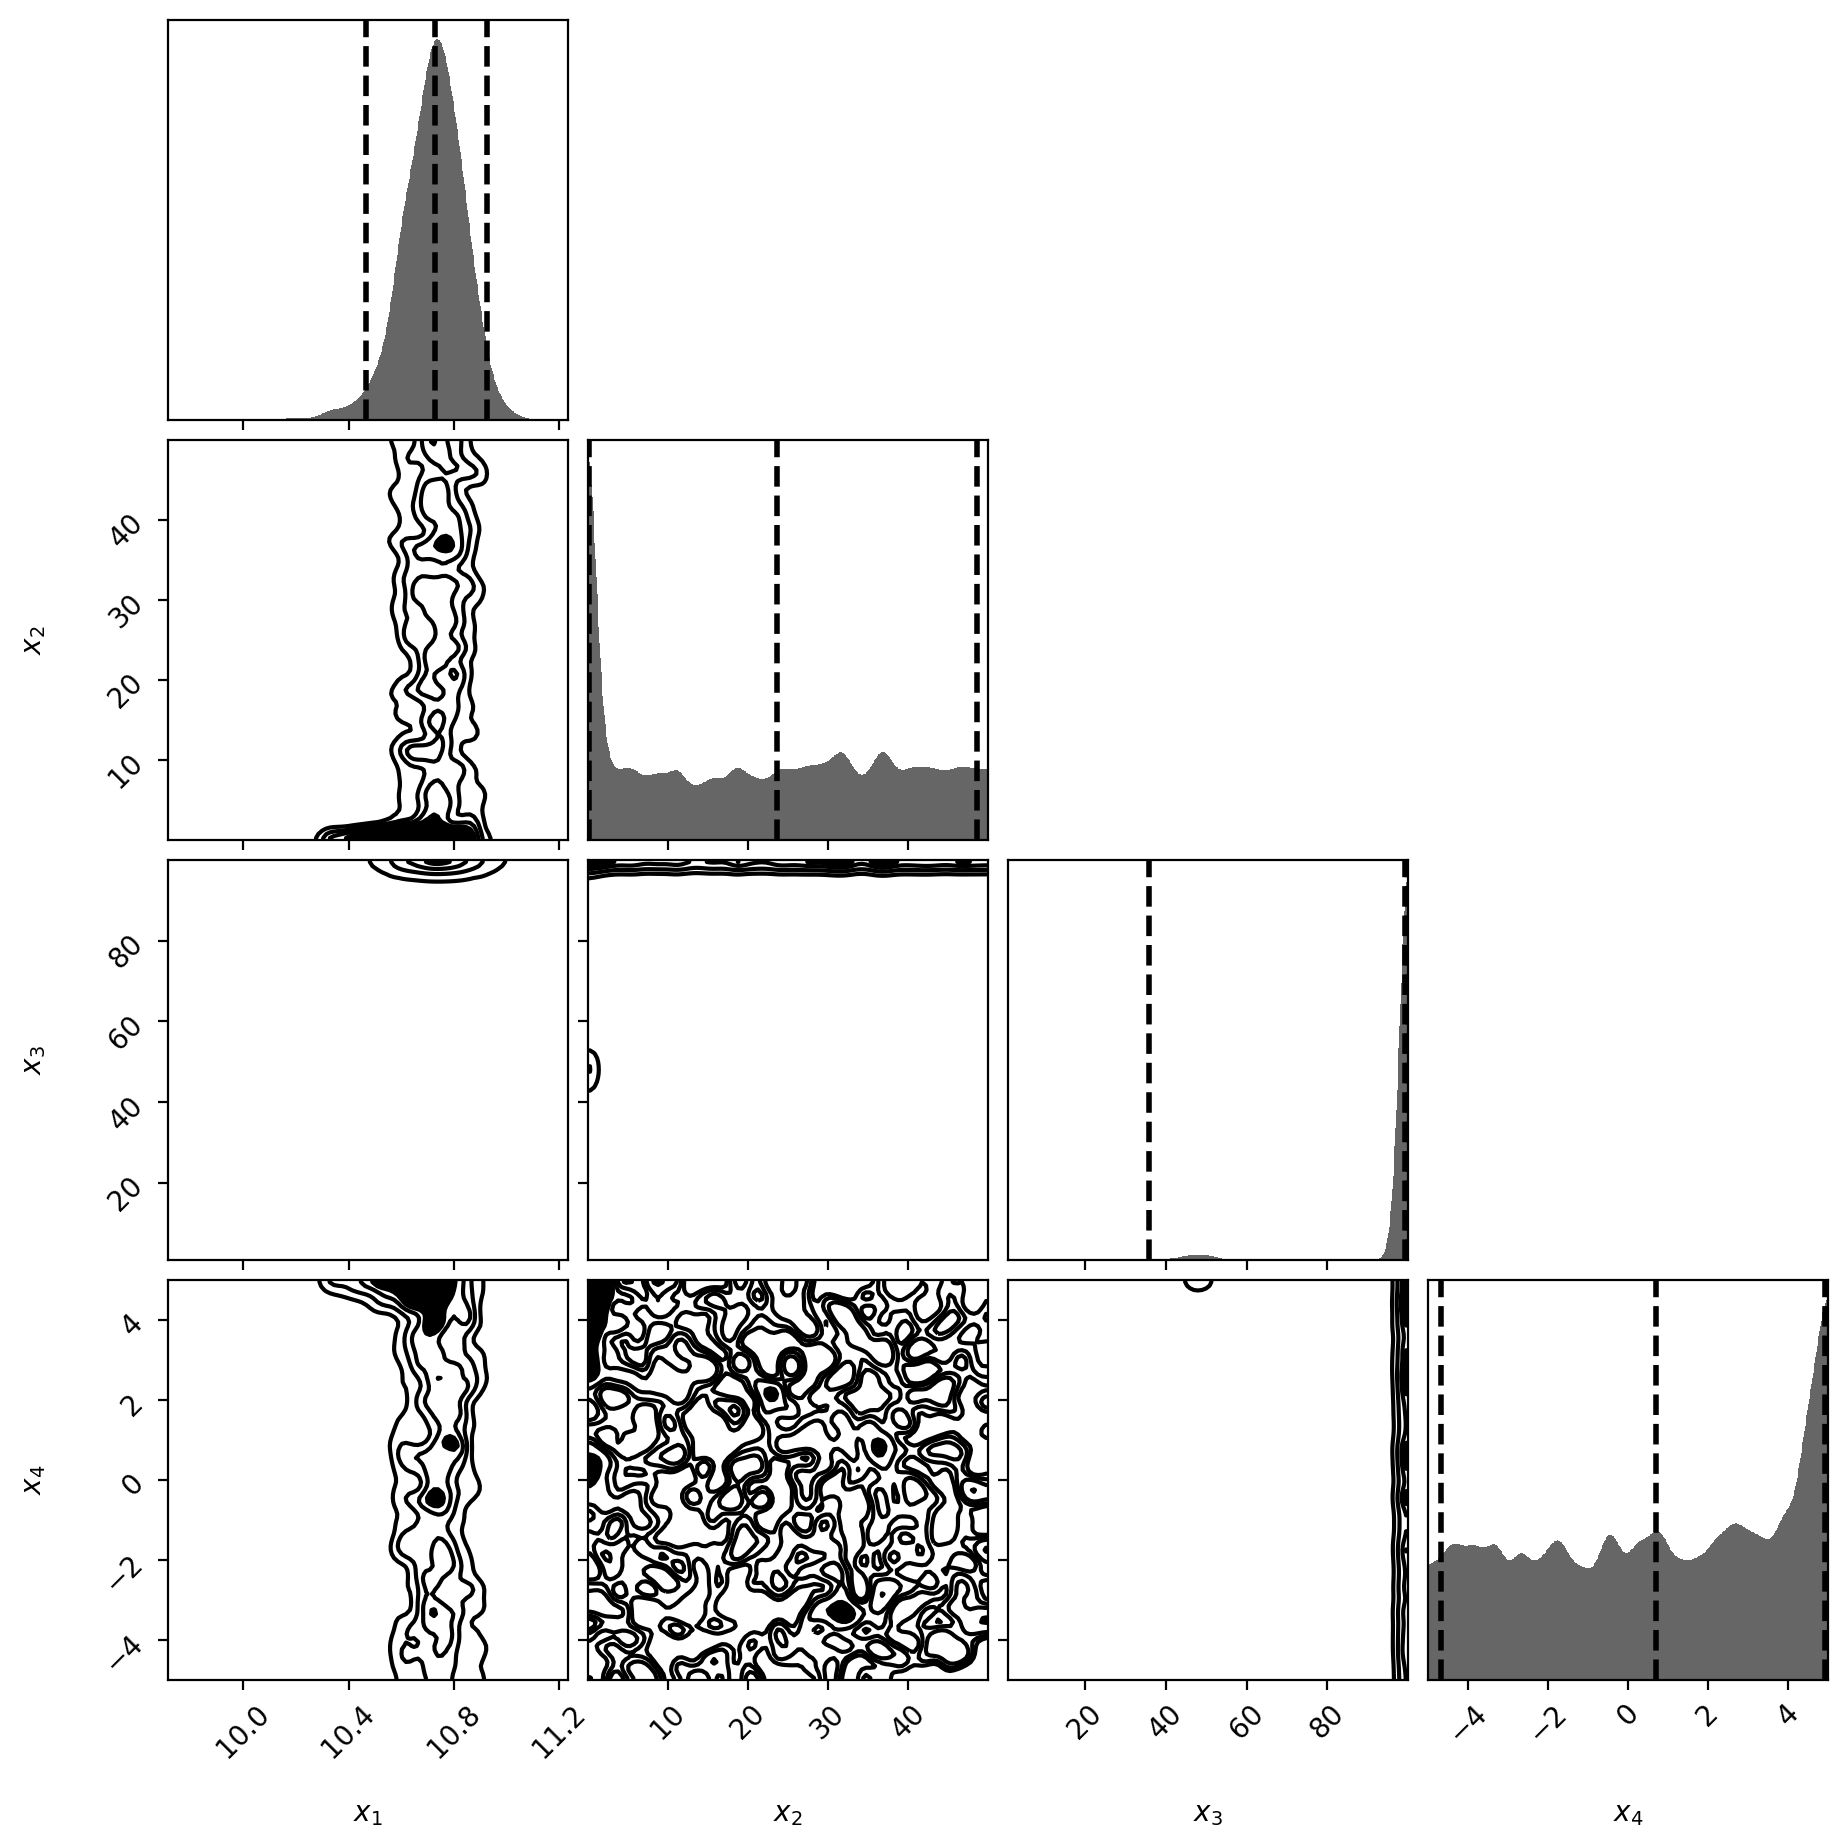

In [371]:
#corner plot
cfig, caxes = dyplot.cornerplot(results_burst)

The above plots look crazy...It is definitely something with my log likelihood function (although it seemed to work well for emcee), but I don't know where to go from here

In [372]:
#bayesian evidence of the gaussian and burst models
bayesian_evidence_g = results_gauss.logz[-1]  # log of the evidence
print(bayesian_evidence_g)

bayesian_evidence_b = results_burst.logz[-1] #log of the evidence
print(bayesian_evidence_b)



-159.58758120668406
-96.69459099872864


The favored description of the data is the burst model, based on the bayesian evidence.